# Cell Transmission Model

_源代码、结果数组文件与图片已开源 Lumozz https://github.com/Lumozz/CTM_

# 设定基本交通特性参数

### 交通流参数  
- 作出假设，对于每条车道：


<center>$ Q_{max}=1800veh/h $  </center>
<center>$ K_{max}=30veh/km$  </center>
<center>$ K_{jam}=125veh/km$  </center>
<center>$ V_{free}=60km/h$  </center>
  
 
- **交通流率**$Q$与**车流密度**$K$关系图简化为三角形. 
- 设定模拟时间间隔（时间步）$t$为3秒.

### 道路结构参数
- 设公路的长度为$3km$,单向两车道.  
- 按照CTM理论，在初始自由流状态下，每经过一个时间步，一个$cell$中的车辆应该刚好行驶到下一个格子中，因此，$cell$长度.  
$l=V_{free}\times t=60km/h \times 3s =50m$  即，1km长的道路被分为20份，每份为50m.
- 此处作出诸多假设，主要是为了验证代码的准确性，在编写完成后，可以在交通流基本理论框架下自由更改这些参数，得到更丰富的仿真结果.

# 仿真算法实现

### 导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### 实现ctm类  
- 初始化超参数
- 实现供给、需求量的计算函数
- 实现固定参数下的仿真迭代运算
- 构造障碍函数，实现stop&go效果

In [2]:
class ctm():
    def __init__(self):
        self.total_step = 250
        self.Q_max_per_lane = 2250 / 3600  # veh/s
        self.K_jam_per_lane = 125 / 1000  # veh/m
        self.V_free_per_lane = 60 / 3.6  # m/s
        self.K_max_per_lane = self.Q_max_per_lane / self.V_free_per_lane

        self.init_rate = 0.8

        self.time_step = 3  # s
        self.g_num_lane = 2
        self.l_road = 3000  # m
        self.l_cell = self.V_free_per_lane * self.time_step
        self.num_cell = self.l_road / self.l_cell + 2

        if self.num_cell % 1 != 0:
            print('错误，路不能被整分')
        else:
            self.num_cell = int(self.num_cell)

        self.capacity = np.ones(self.num_cell) * self.K_jam_per_lane * self.l_cell
        self.capacity[0] = 999
        self.capacity[-1] = 999

        self.occupancy = np.zeros(self.num_cell)
        self.occupancy[0] = self.init_rate * self.K_max_per_lane * self.l_cell

        self.num_lane = np.ones(self.num_cell) * self.g_num_lane

        self.block_position = self.num_cell - 1
        self.release_time = 1

    def get_Q_in(self, occupancy):
        k = occupancy / self.l_cell

        if k <= self.Q_max_per_lane / self.V_free_per_lane:
            q = self.Q_max_per_lane
        else:
            q = -((self.Q_max_per_lane) / (self.K_jam_per_lane - self.K_max_per_lane)) * (k - self.K_jam_per_lane)
        return q

    def get_Q_out(self, occupancy):
        k = occupancy / self.l_cell
        if k <= self.Q_max_per_lane / self.V_free_per_lane:
            q = (self.Q_max_per_lane / self.K_max_per_lane) * k
        else:
            q = self.Q_max_per_lane
        return q

    def get_Q(self, occupancy):

        k = occupancy / self.l_cell
        q = k.copy()

        q[q >= self.Q_max_per_lane / self.V_free_per_lane] = 999

        q[q < self.Q_max_per_lane / self.V_free_per_lane] = (self.Q_max_per_lane / self.K_max_per_lane) * \
                                                            k[k < self.Q_max_per_lane / self.V_free_per_lane]

        q[q >= 998] = \
            -((self.Q_max_per_lane) / (self.K_jam_per_lane - self.K_max_per_lane)) * \
            (k[k >= self.Q_max_per_lane / self.V_free_per_lane] - self.K_jam_per_lane)

        return q

    def get_V(self, occupancy):
        k = occupancy / self.l_cell
        q = self.get_Q(occupancy)
        k[k>0] = q[k>0] / k[k>0]

        return k

    def set_block(self, position, release_time):
        self.block_position = position
        self.release_time = release_time
        self.capacity[self.block_position] = 0

    def sim(self):
        self.occupancy_next = np.zeros_like(self.occupancy)
        log = np.zeros_like(self.occupancy)

        for step in range(0, self.total_step):
            if step == self.release_time:
                self.capacity[self.block_position] = self.K_jam_per_lane * self.l_cell
            for i in range(0, self.num_cell):
                if i == 0 or i == self.num_cell - 1:
                    self.occupancy_next[i] = self.occupancy[i]
                    continue

                num_in = min(self.get_Q_out(self.occupancy[i - 1]) * self.num_lane[i - 1] * self.time_step, \
                             self.get_Q_in(self.occupancy[i]) * self.num_lane[i] * self.time_step)
                cell_in = min(self.occupancy[i - 1] * self.num_lane[i - 1], num_in, \
                              self.capacity[i] * self.num_lane[i] - self.occupancy[i] * self.num_lane[i])

                num_out = min(self.get_Q_out(self.occupancy[i]) * self.num_lane[i] * self.time_step, \
                              self.get_Q_in(self.occupancy[i + 1]) * self.num_lane[i + 1] * self.time_step)
                cell_out = min(self.occupancy[i] * self.num_lane[i], num_out, \
                               self.capacity[i + 1] * self.num_lane[i + 1] - self.occupancy[i + 1] * self.num_lane[
                                   i + 1])

                self.occupancy_next[i] = (self.occupancy[i] * self.num_lane[i] + cell_in - cell_out) / self.num_lane[i]
            self.occupancy = self.occupancy_next.copy()
            log = np.vstack([log, self.occupancy])
            tlog = log * self.num_lane

        result_occupancy_lane = log
        result_occupancy_total = tlog

        result_K_lane = log / self.l_cell
        result_K_total = tlog / self.l_cell

        result_Q_lane = self.get_Q(log)
        result_Q_total = result_Q_lane * self.num_lane

        result_V_lane = self.get_V(log)
        result_V_total = result_V_lane
        return result_occupancy_lane, result_occupancy_total, \
               result_K_lane, result_K_total, \
               result_Q_lane, result_Q_total, \
               result_V_lane, result_V_total

- 在`sim()`函数中，每一个$cell$,在时刻$t$,计算输入车辆数与输出车辆数，即计算前一个$cell$的需求量和对后一个$cell$的供给量，方法如下：   



<center>$cell_{in}^{i} = min(cell_{occupancy}^{i-1},min(Q^{i-1},Q^{i}),cell_{capacity}^{i}-cell_{occupancy}^{i})$ </center>   

<center>$cell_{out}^{i} = min(cell_{occupancy}^{i},min(Q^{i},Q^{i+1}),cell_{capacity}^{i+1}-cell_{occupancy}^{i+1})$ </center>  
  
  
    - 其中，等式左边为当前时刻量，等式右边为$t-1$时刻量。由此可得，当前时刻所有$cell$的输入输出量只与上一时刻的系统状态相关，与当前时刻其他$cell$的量无关，因此不需要按照特定的顺序计算。    
式中第二项$min(Q^{i-1},Q^{i})$与$min(Q^{i},Q^{i+1})$为$cell^{i}$的受交通量的影响而限制的输入与输出量，通过`get_Q_in`与`get_Q_out`函数计算。  
    - 需要注意的是，这里的输入、输出量，与需求、供给量不是对等关系，要加以区分。  

    - 最后：  


<center>$cell_{t}^{i}=cell_{t-1}^{i}+cell_{in}^{i}-cell_{out}^{i}$</center>  
  
- `set_block()`函数是为了实现stop and go效果而存在的。
    - 在这个函数中，使用了一种简便的方法，即设置某一段$cell$的容纳能力为零（`self.capacity[i]=0`），这样以来，前一节点的交通流就无法流入这一节点，按照上式计算，这一节点的需求量、流入量一直为零。车辆行驶到这里必须原地等待。
    - 进一步的，为了实现自动化仿真，设定一个**放开时间**，即运行到某一个时间步时，恢复这一$cell$原有的容纳能力，这样车辆就能像通过其他$cell$一样继续驶向终点。

# 仿真与绘图  
- 直观的图像是观察交通状态的良好工具，这里，以时间步为横坐标，道路长度为纵坐标，绘制每一个$cell$的车辆Num、密度K、流率Q、速度V的数热力图，每一项又分为单车道与所有车道总量。  

In [3]:
def pic(start,end,position=40,release_time=70):
    model = ctm()
    if start!=end:
        model.num_lane[start:end] = 3
        
    model.set_block(position,release_time)
    
    result_occupancy_lane,result_occupancy_total,\
                result_K_lane,result_K_total,\
                result_Q_lane,result_Q_total,\
                result_V_lane,result_V_total\
    = model.sim()
    

    return result_occupancy_lane,result_occupancy_total,\
                result_K_lane,result_K_total,\
                result_Q_lane,result_Q_total,\
                result_V_lane,result_V_total

### shock absorber

为了测试shock absorber对交通流产生的影响，这里测试了15个不同长度的shock absorber，均为从阻塞产生处开始，向上游方向延长0到15个$cell$的长度，仿真结果如下。

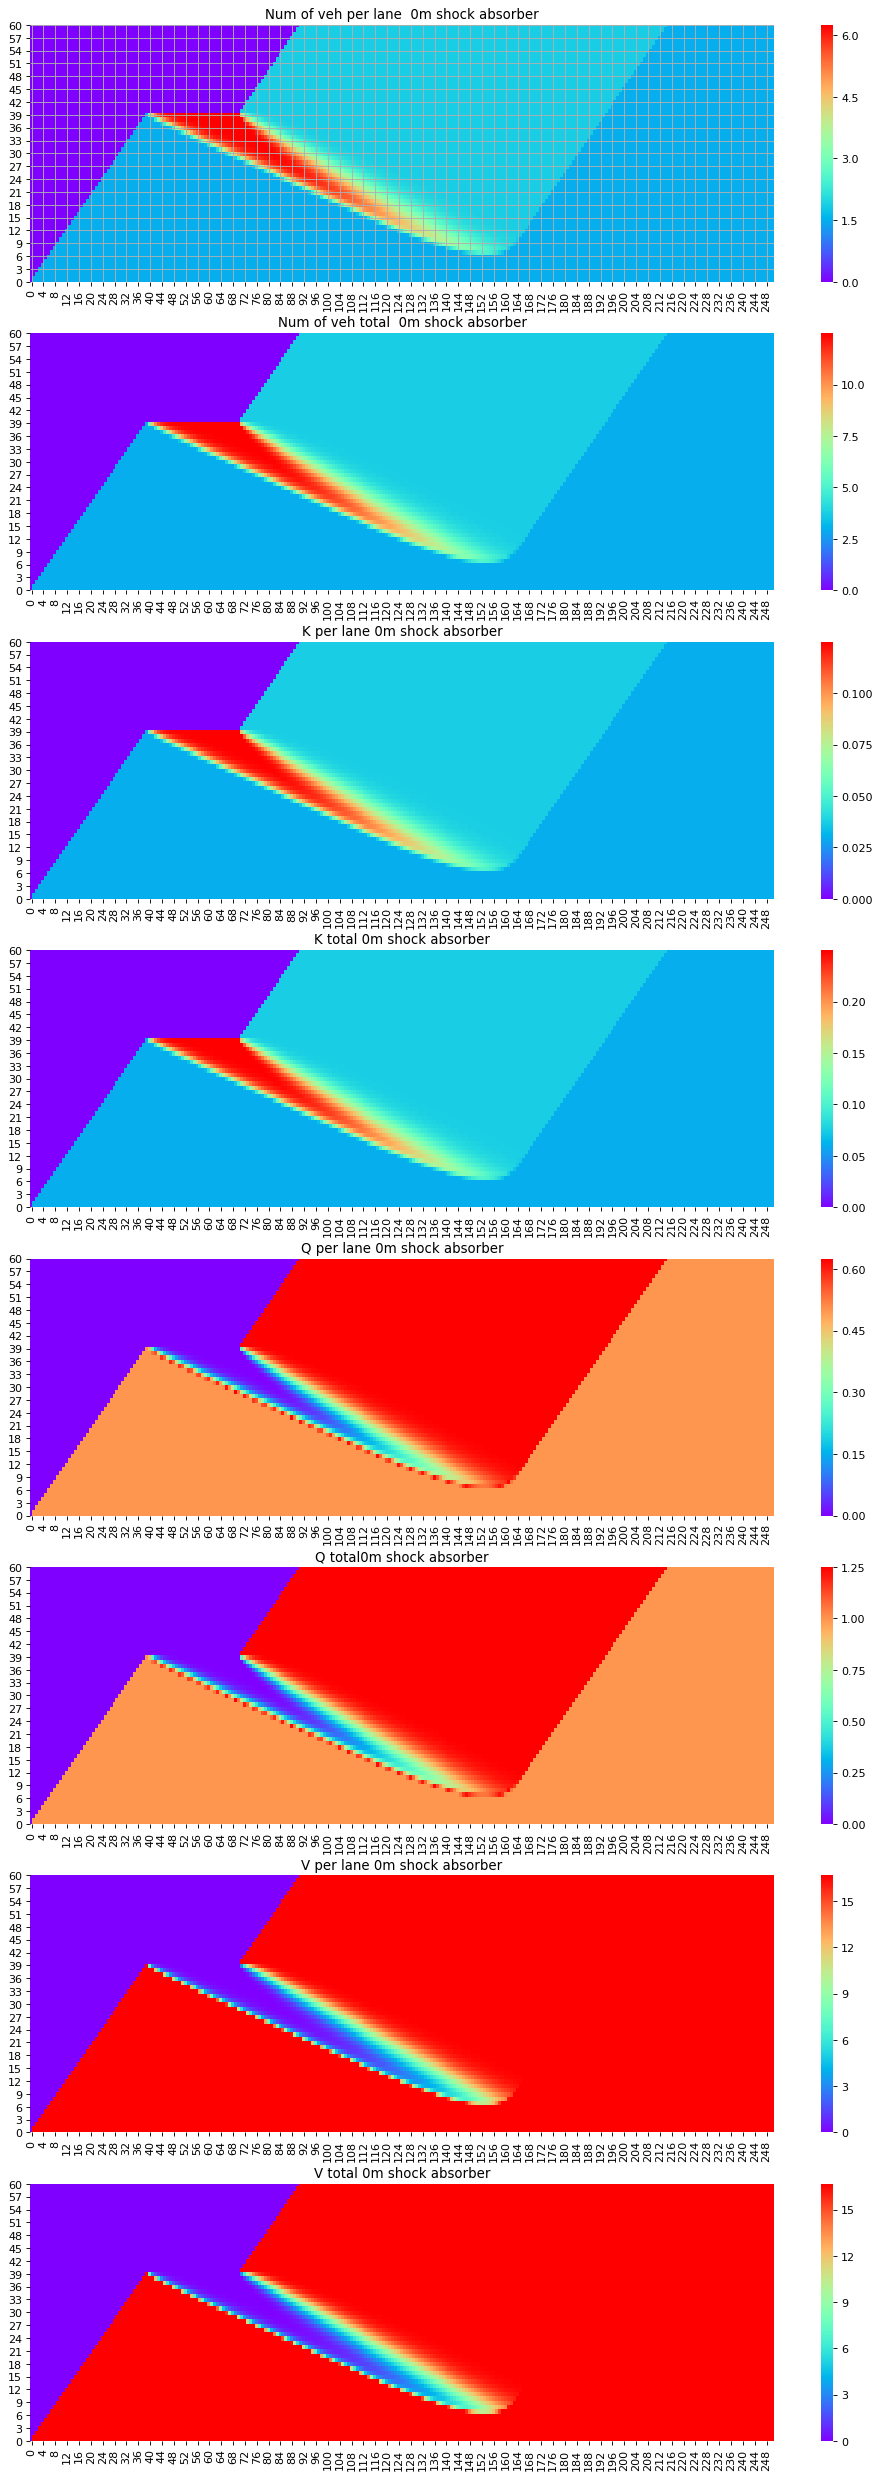

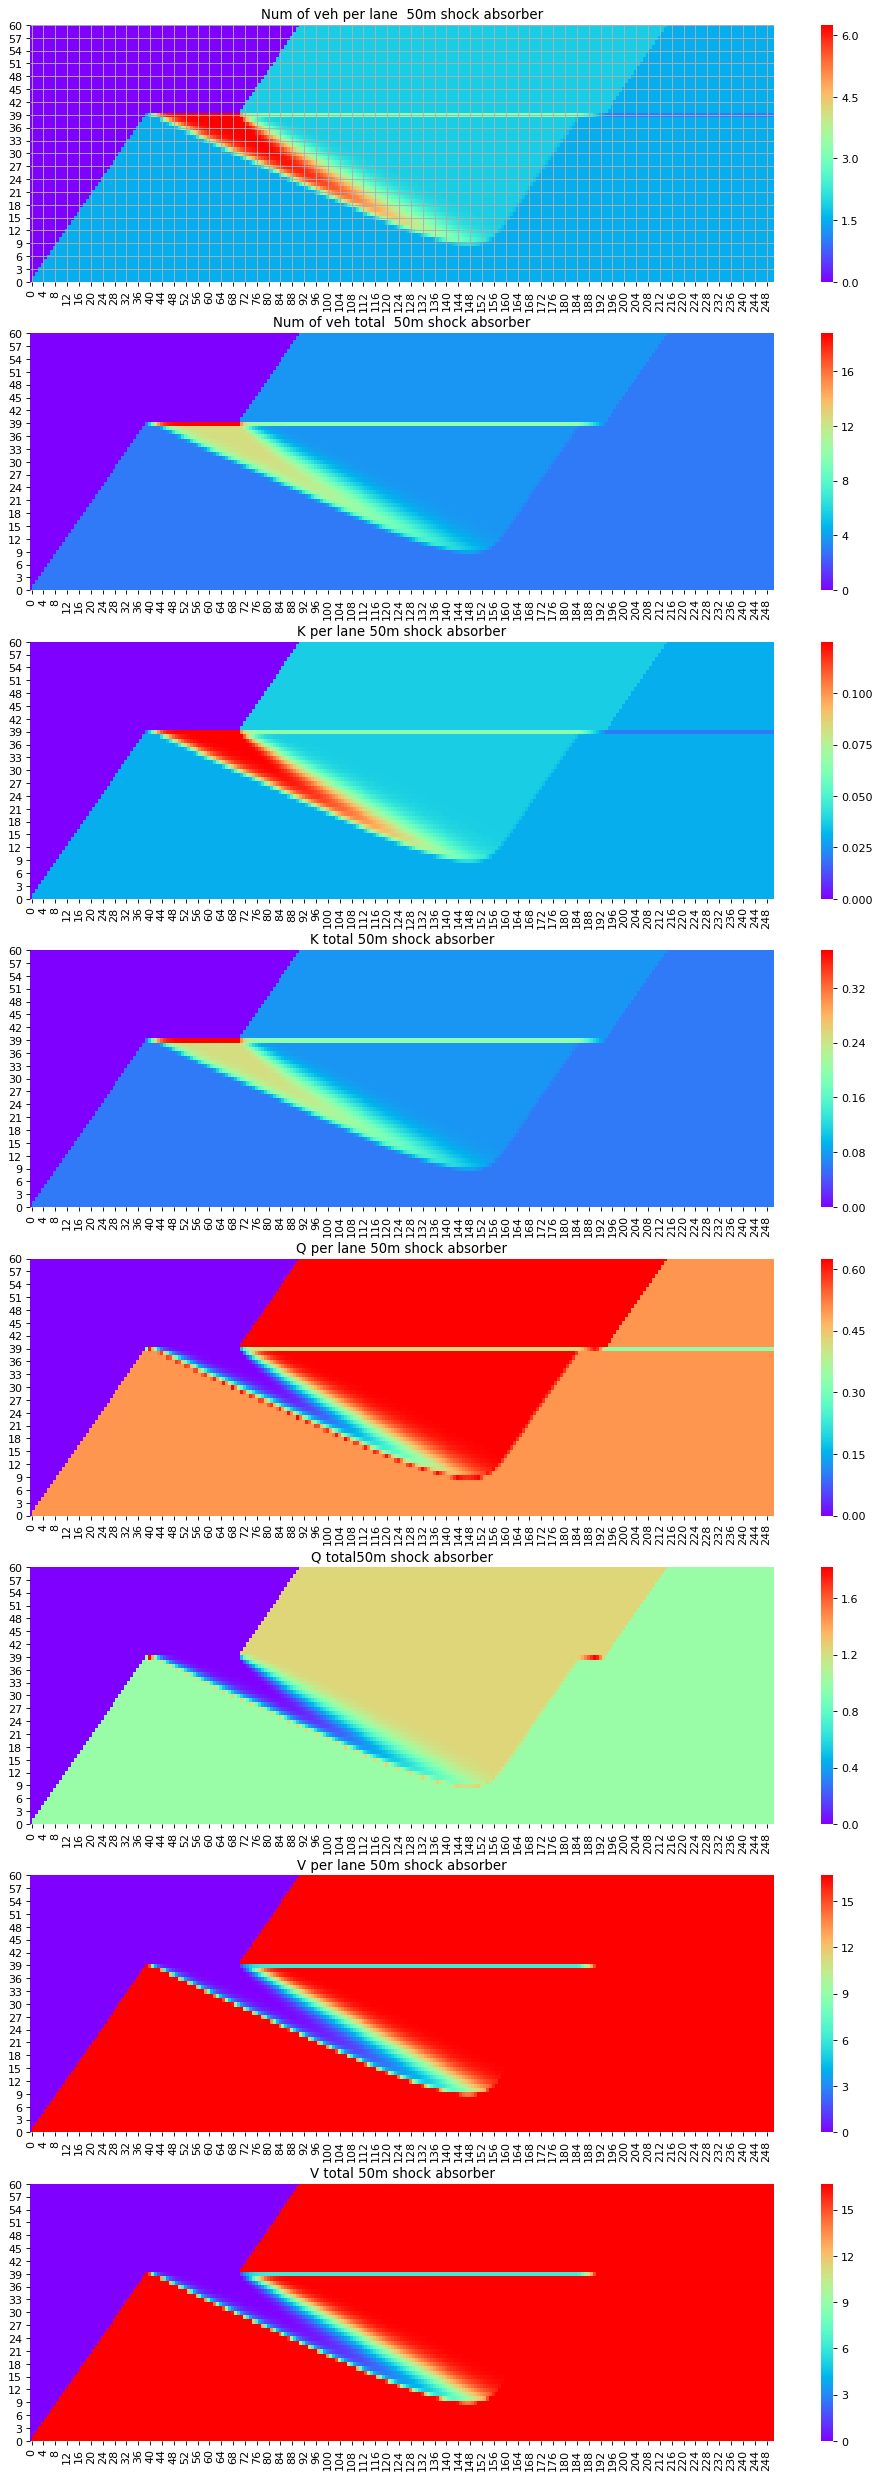

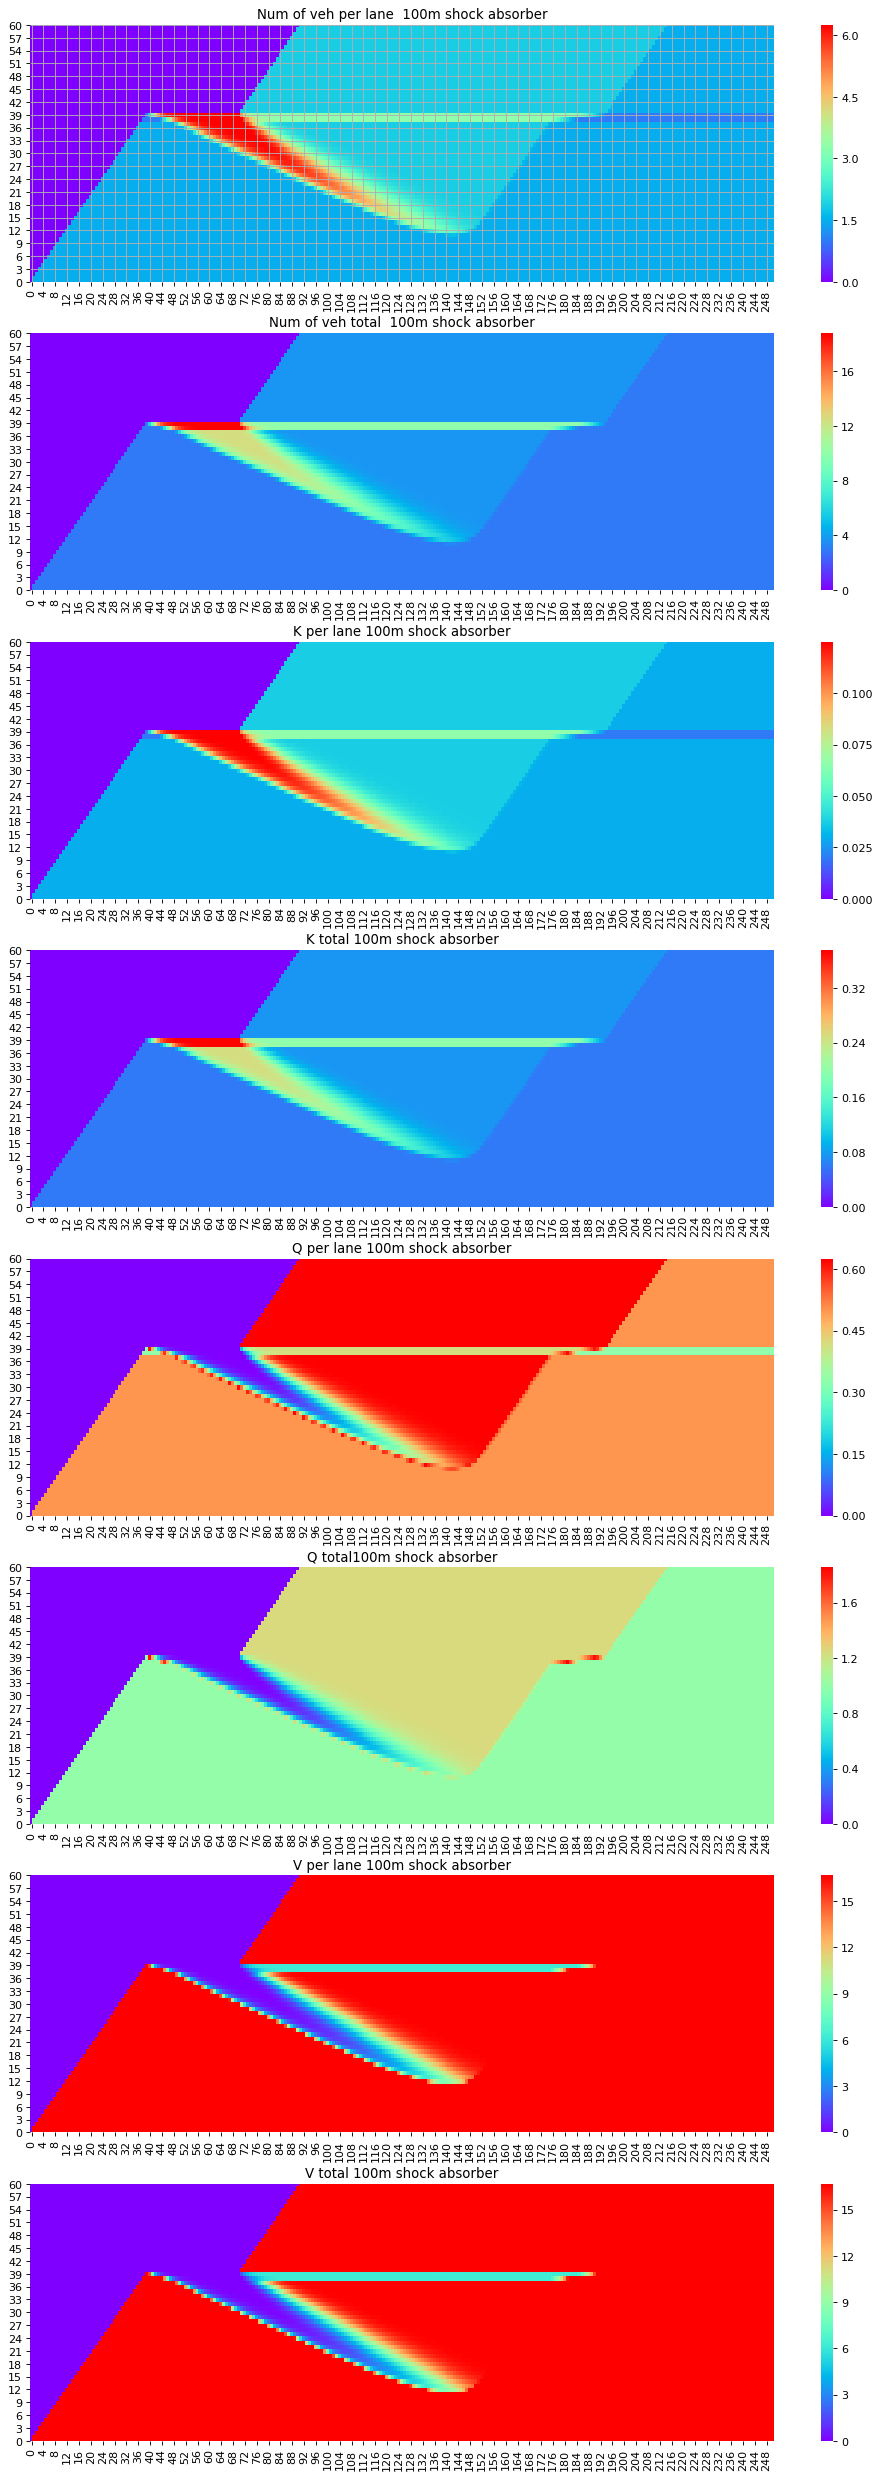

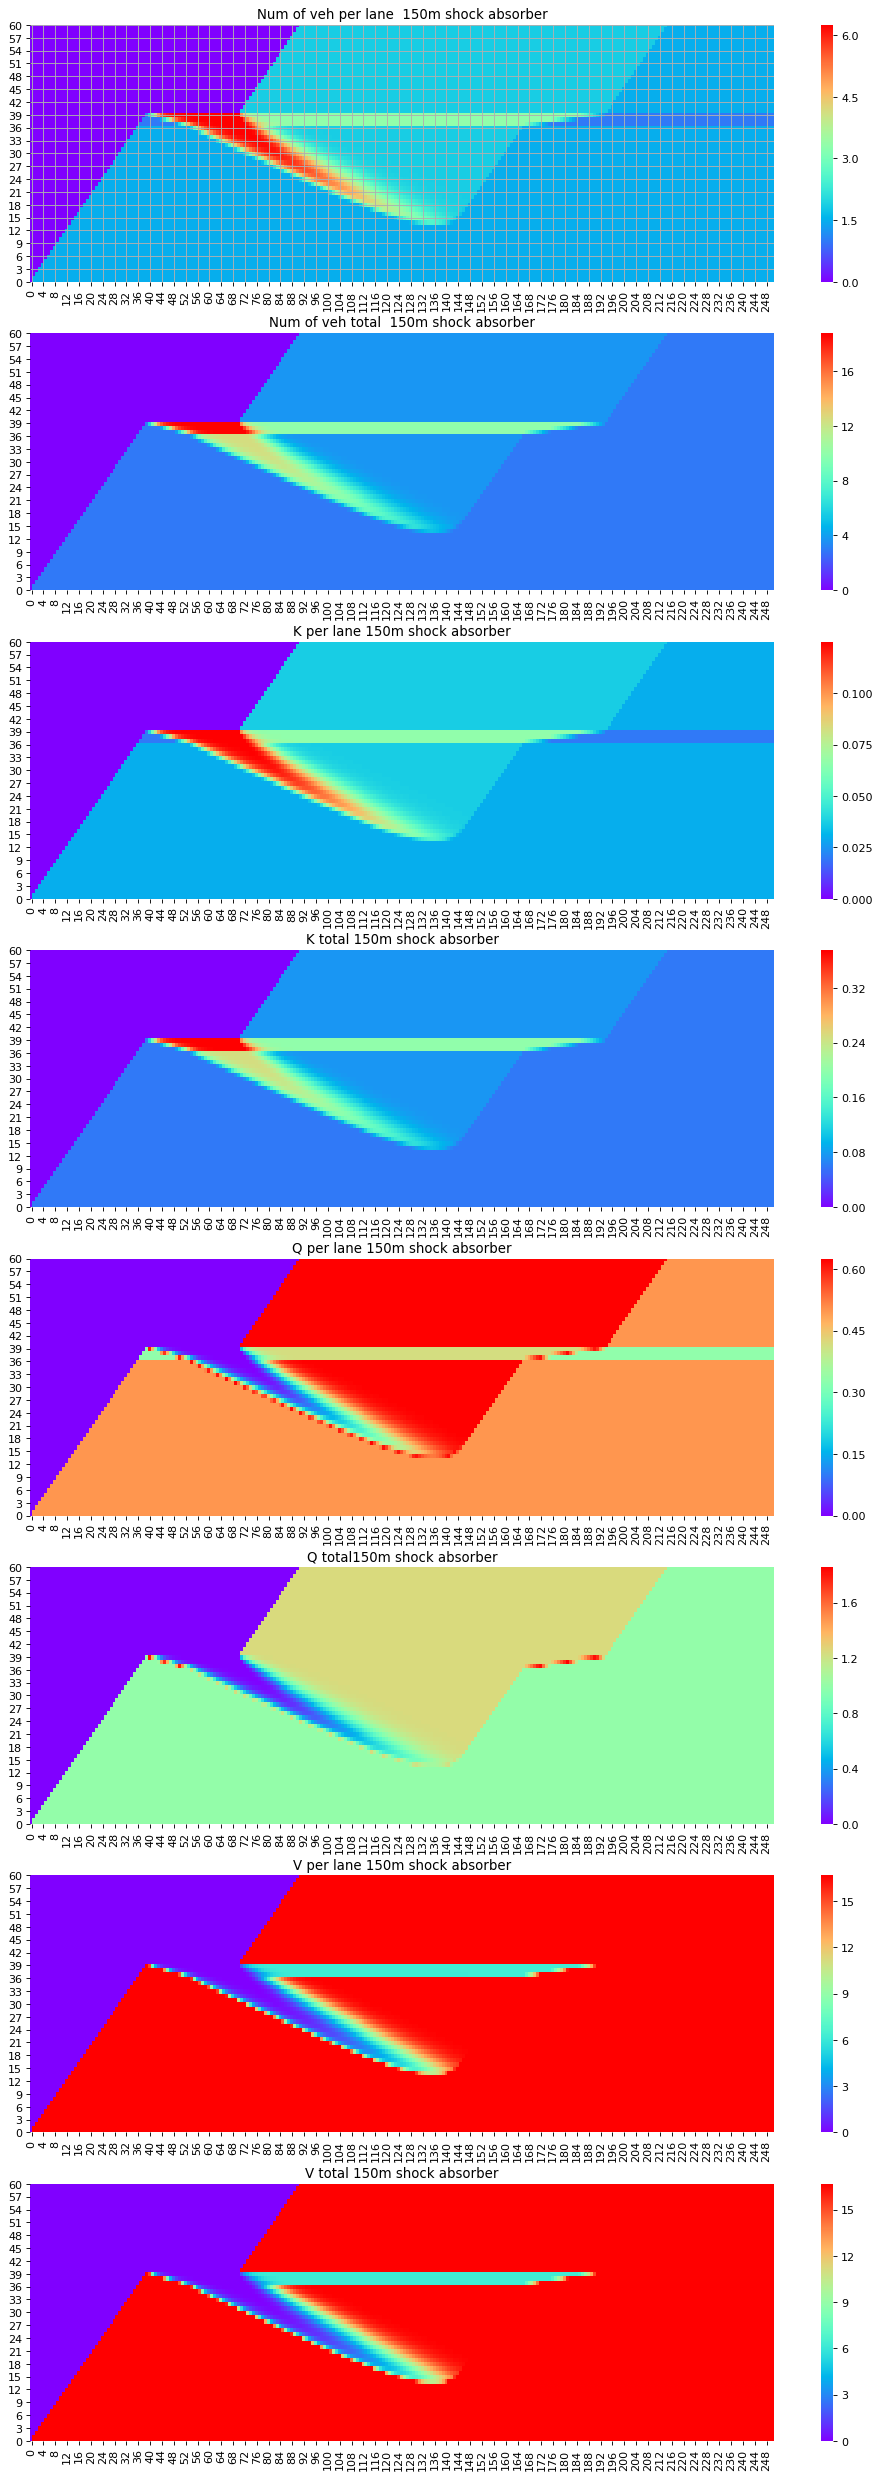

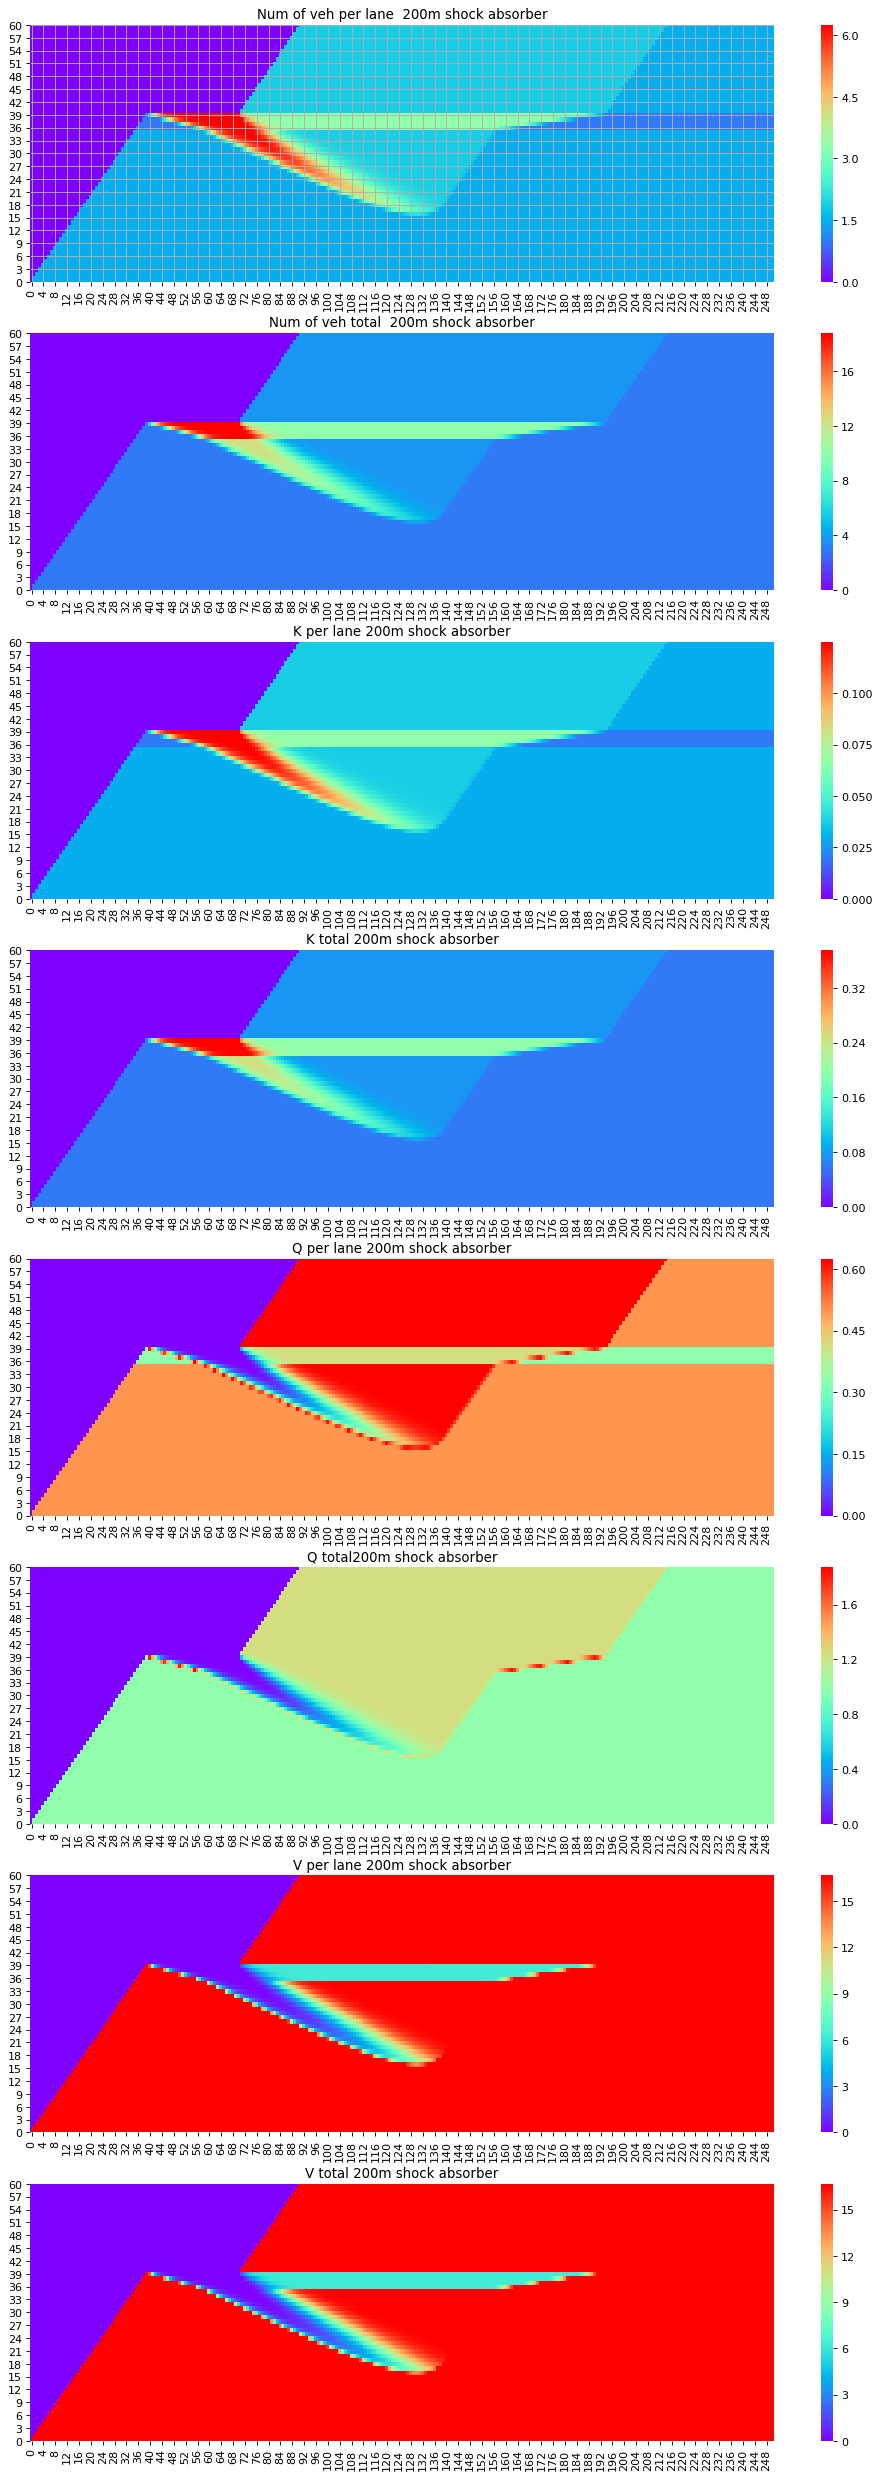

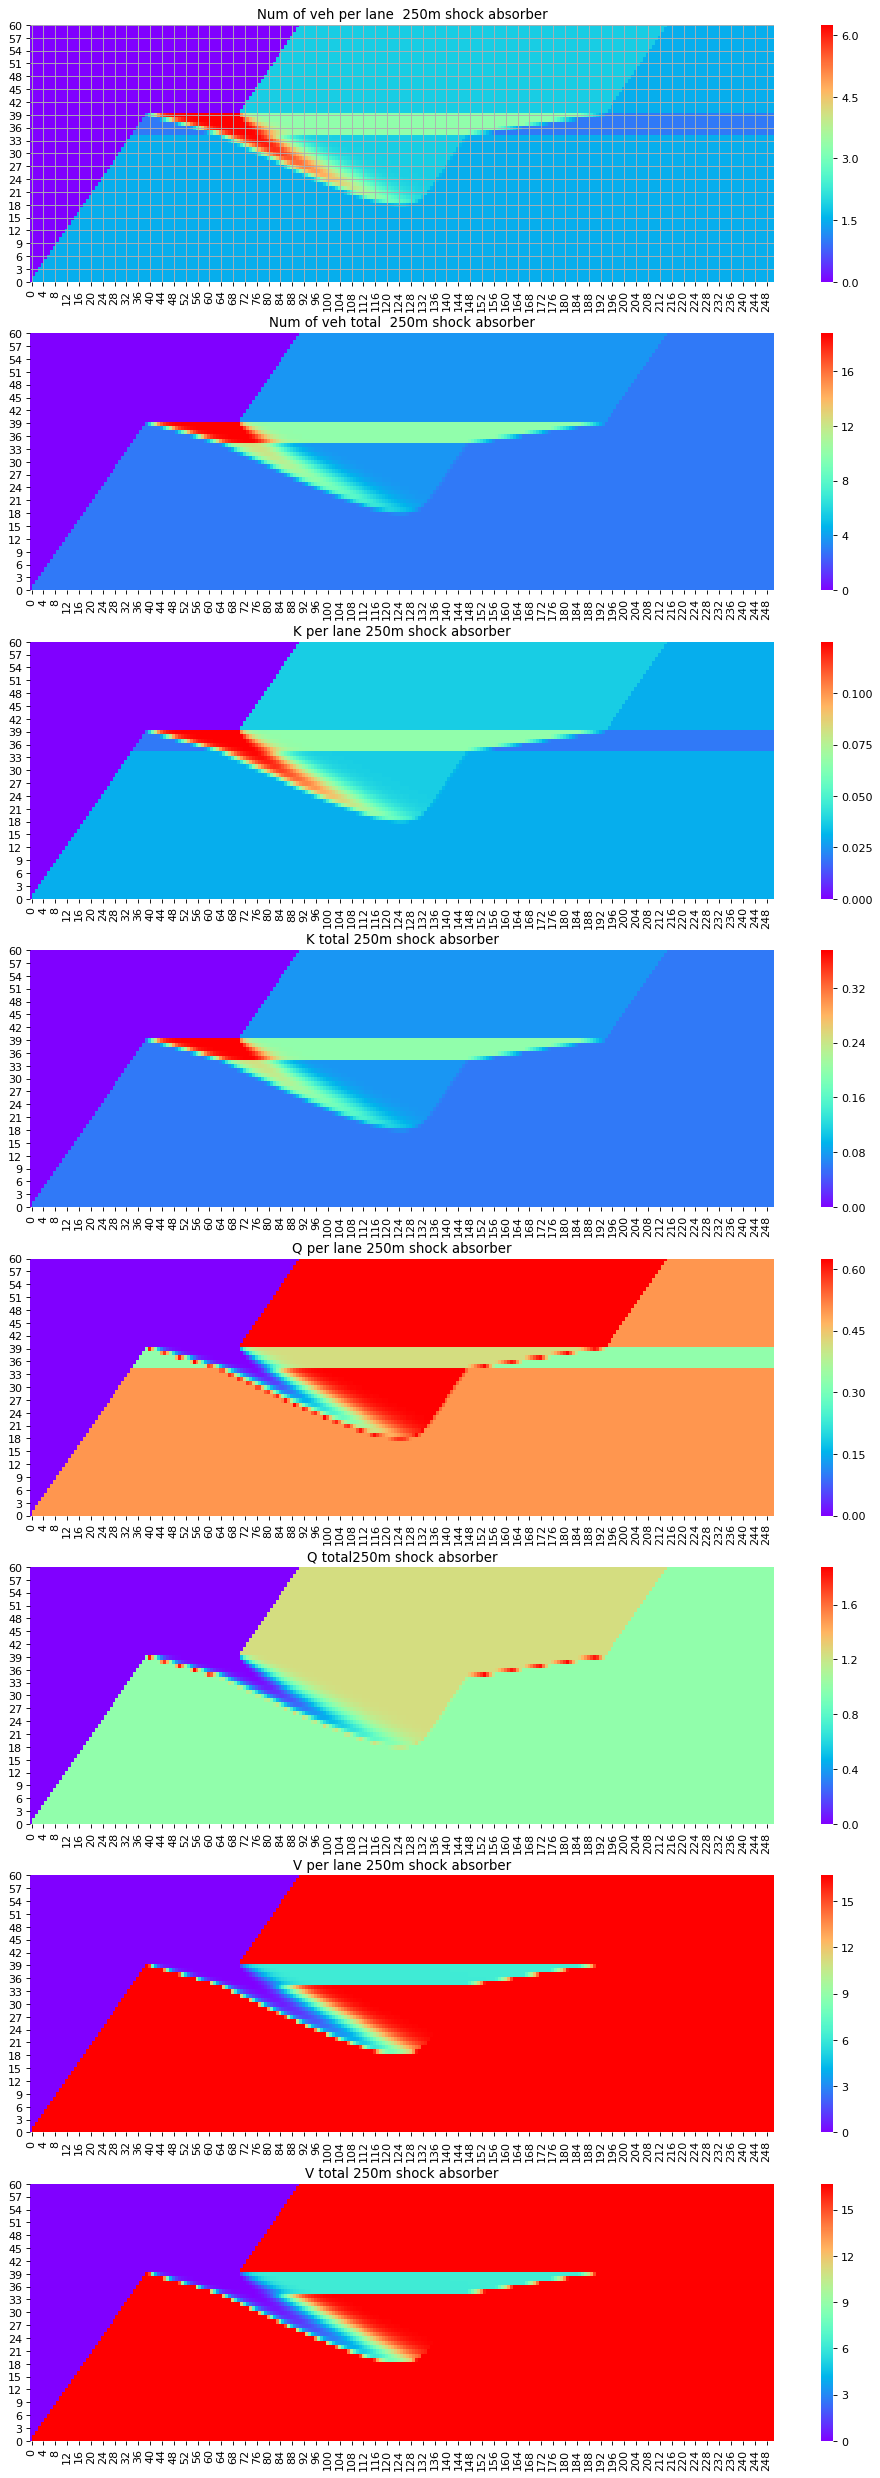

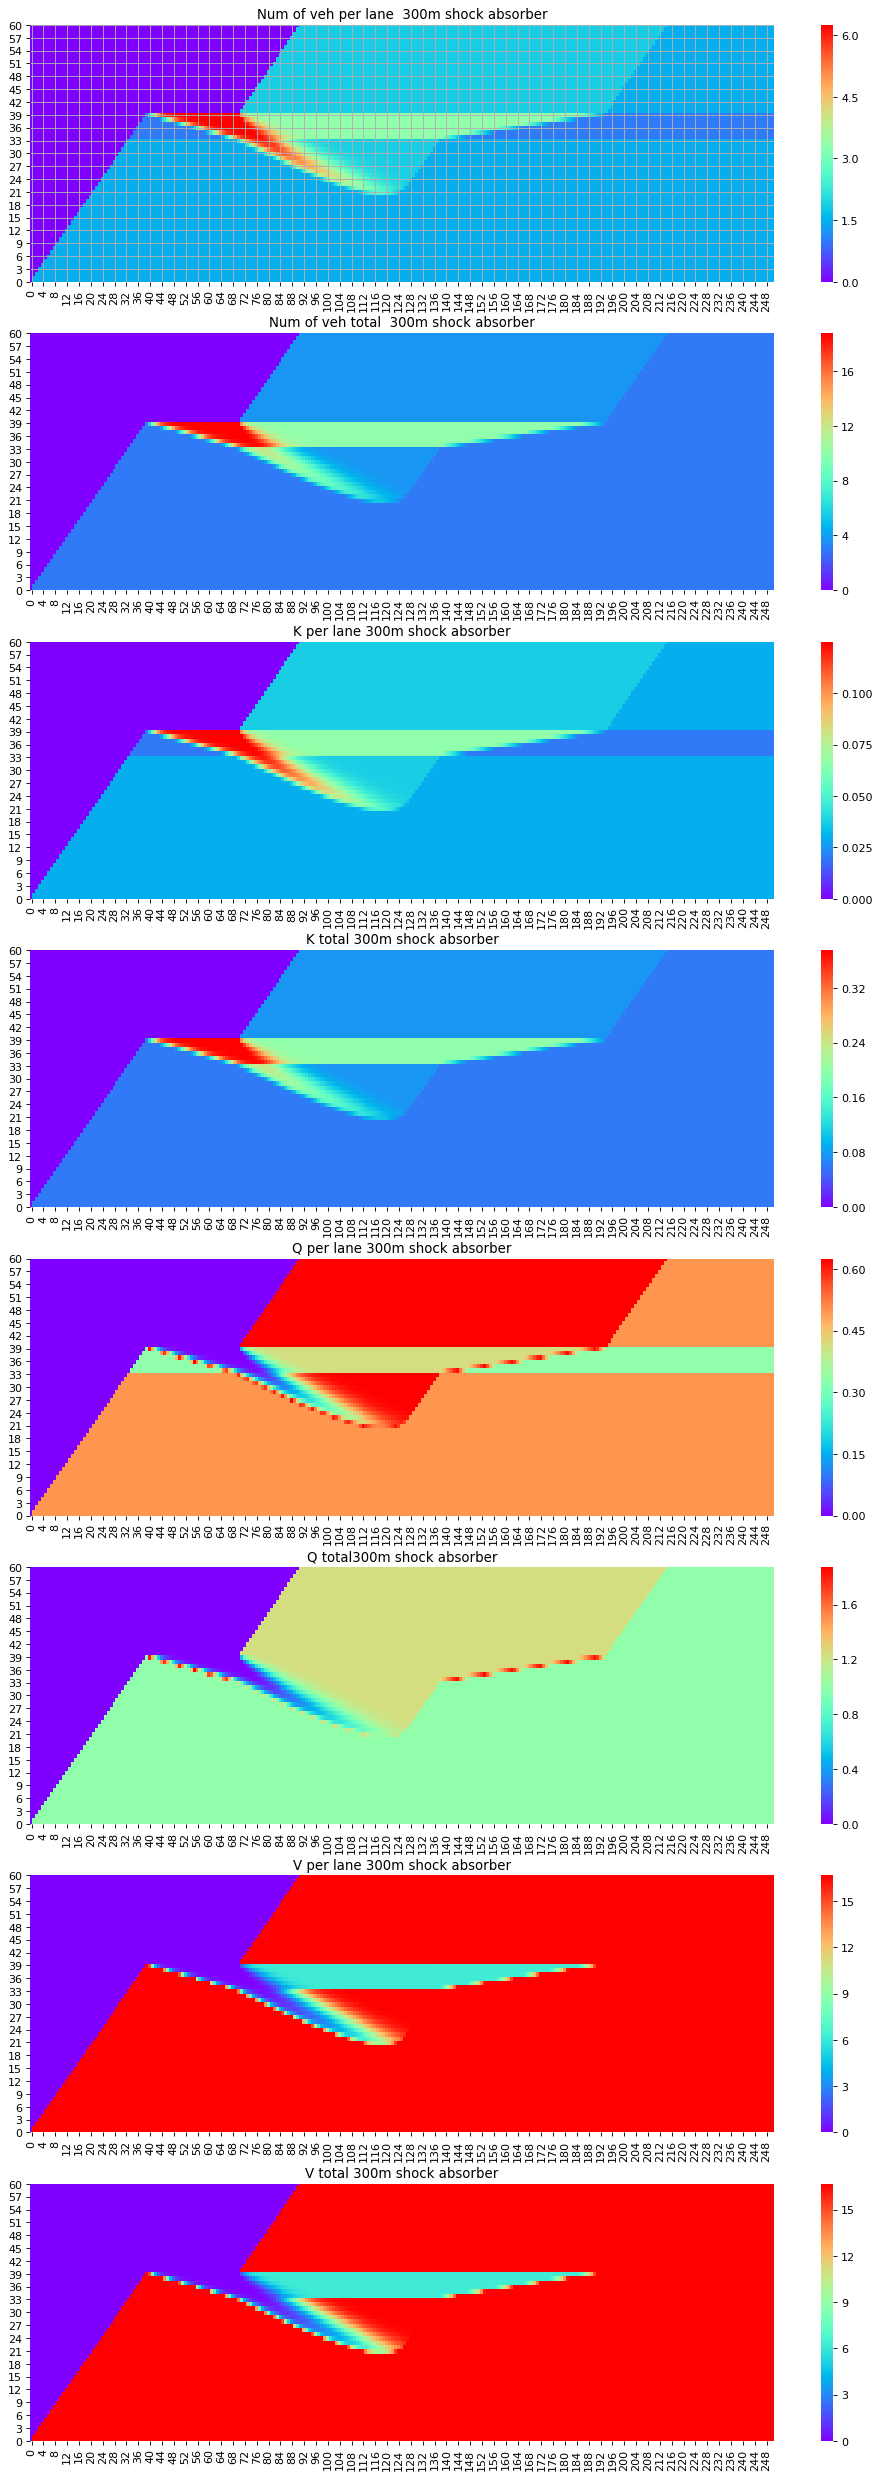

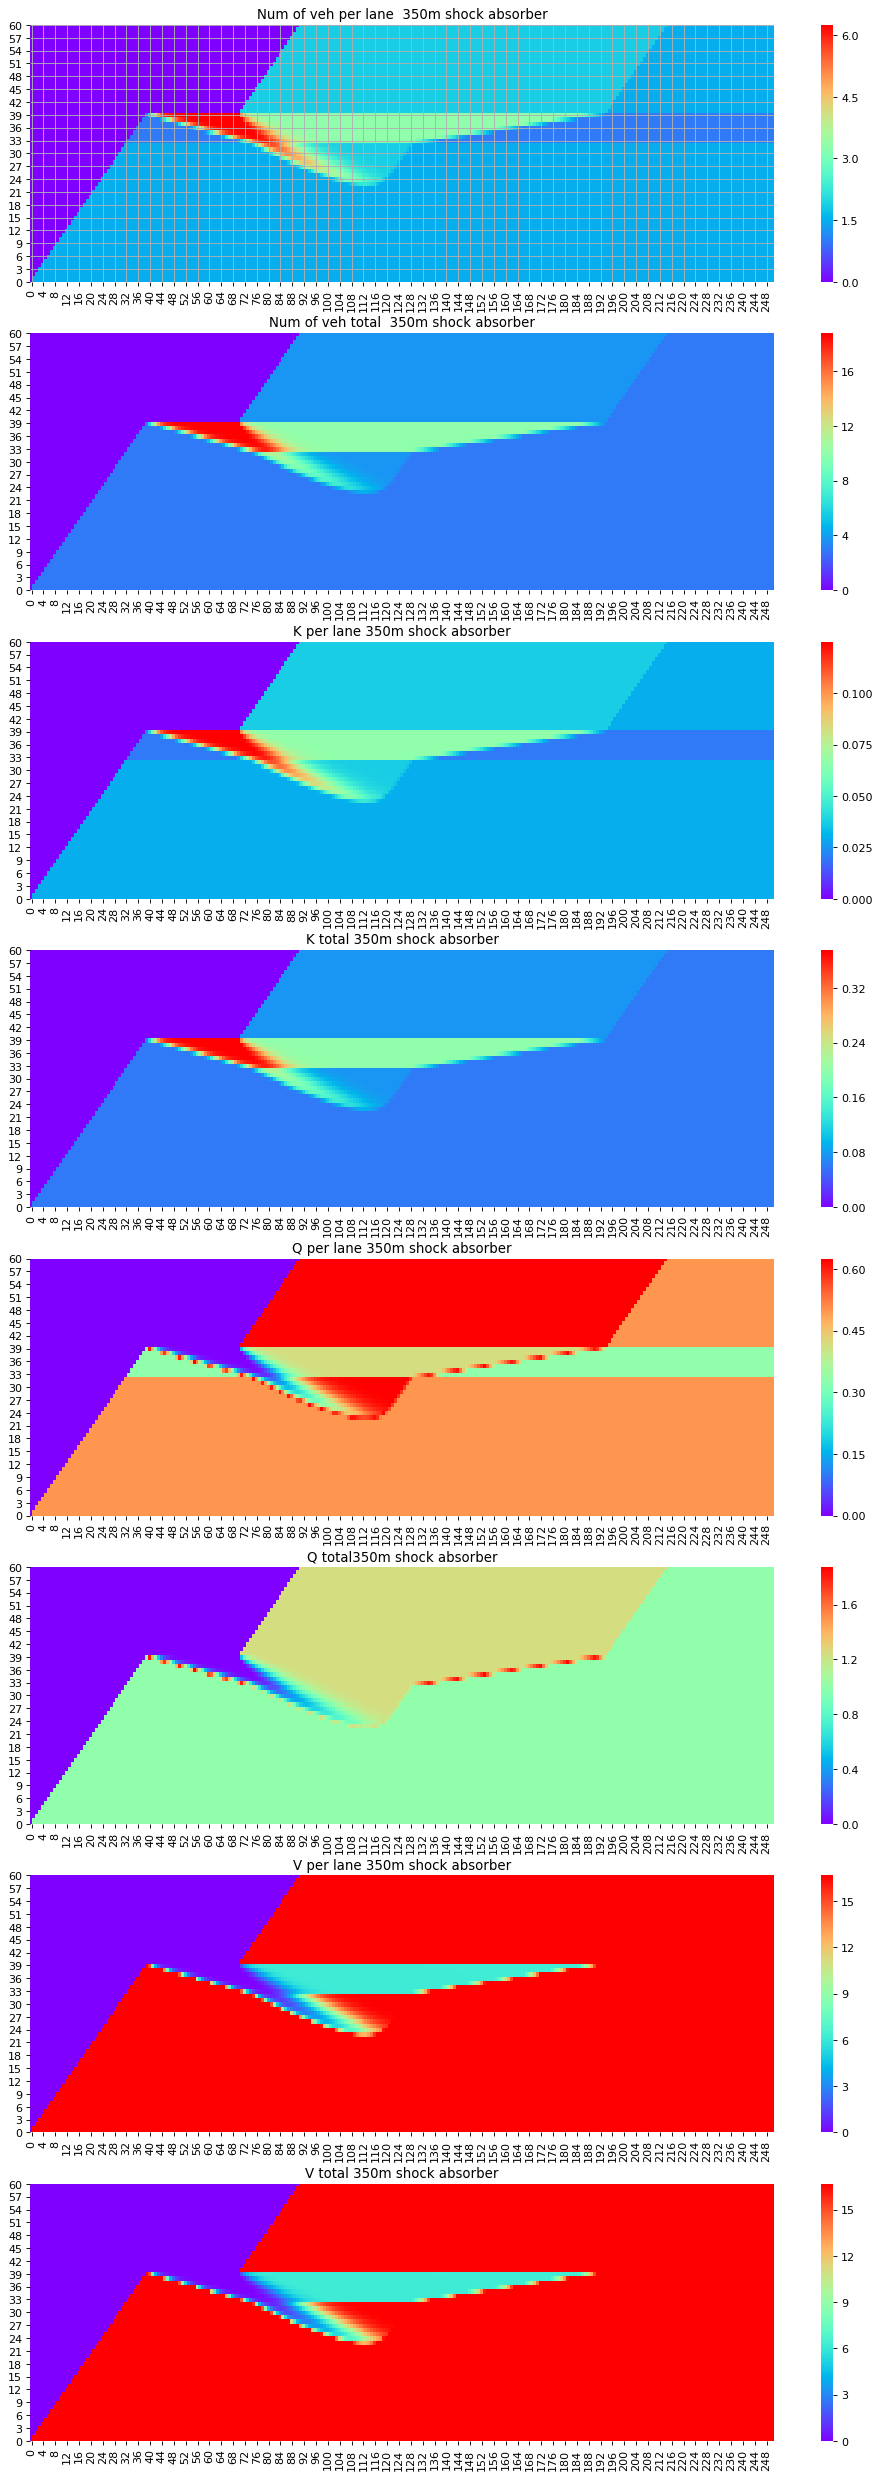

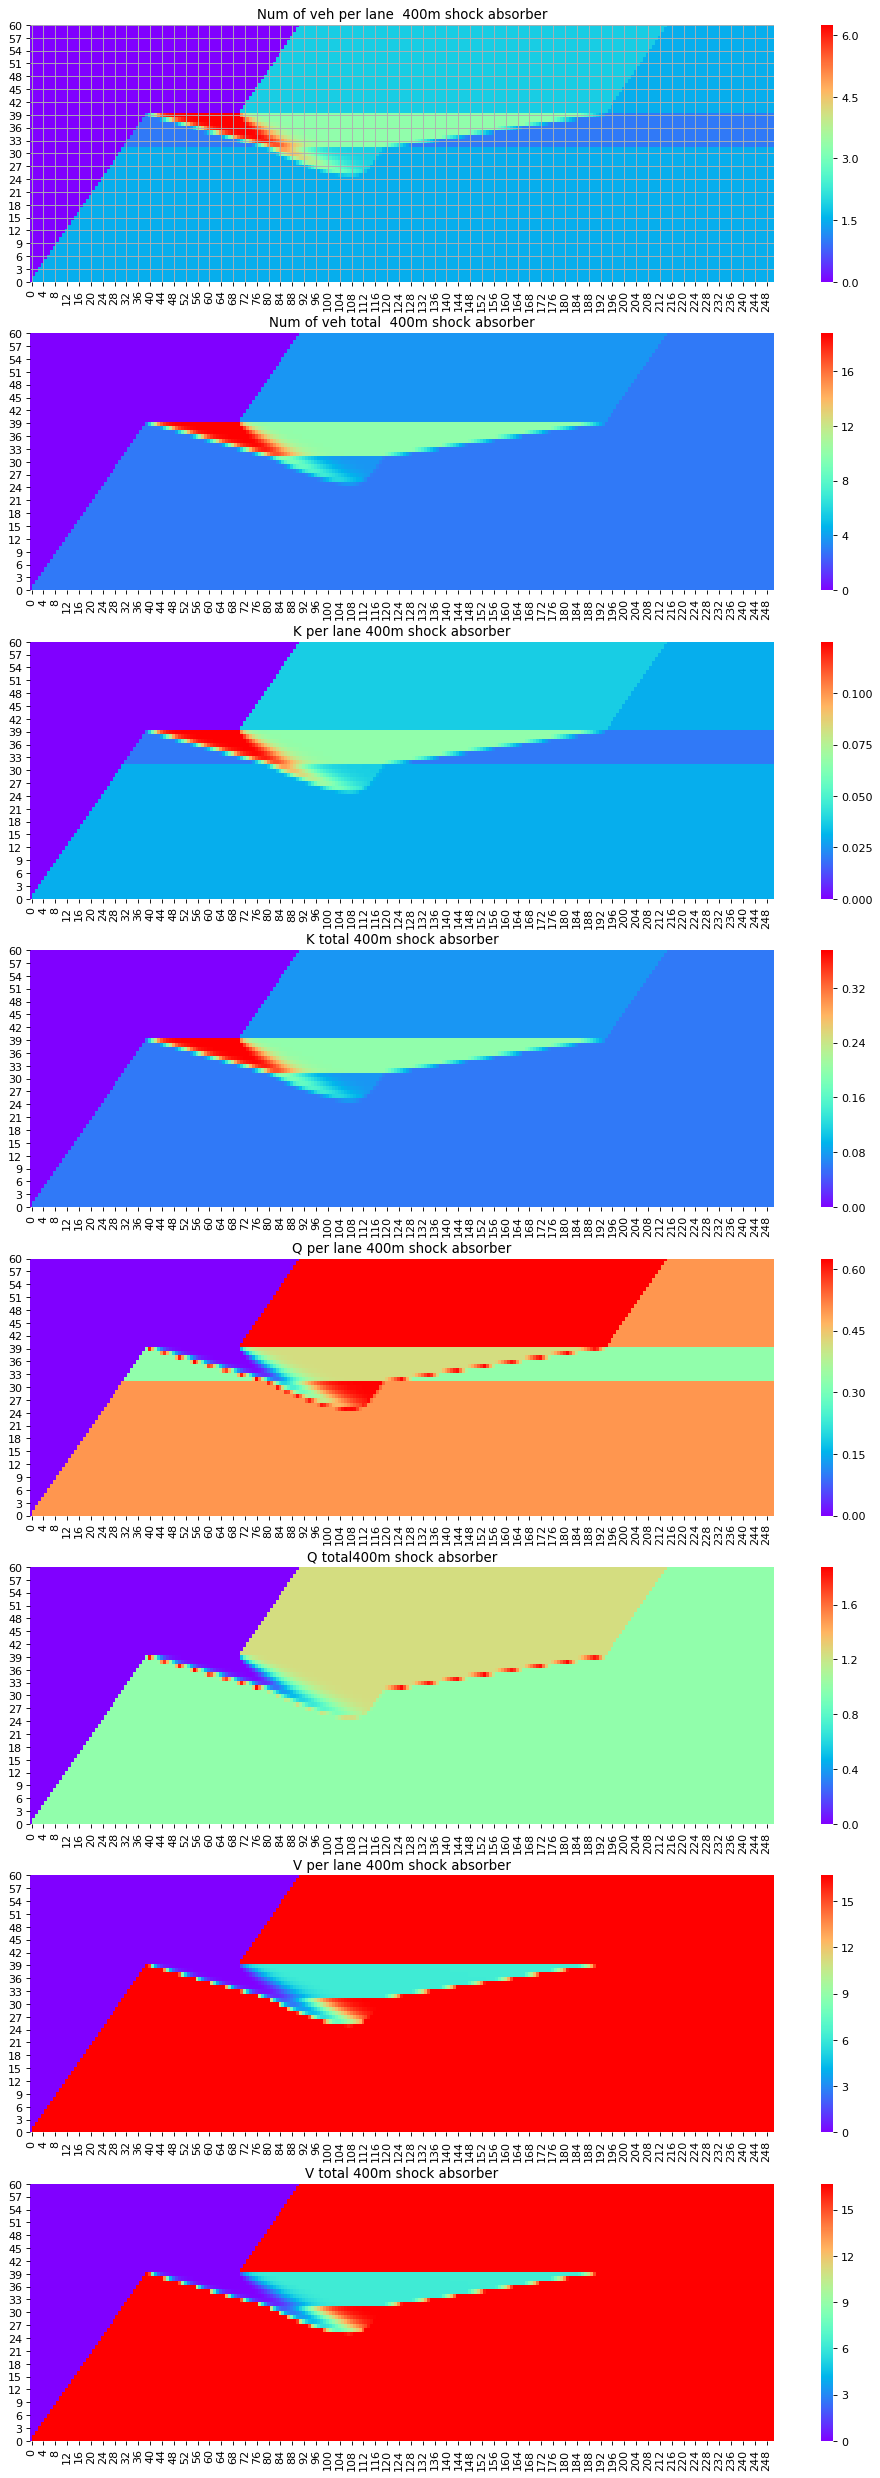

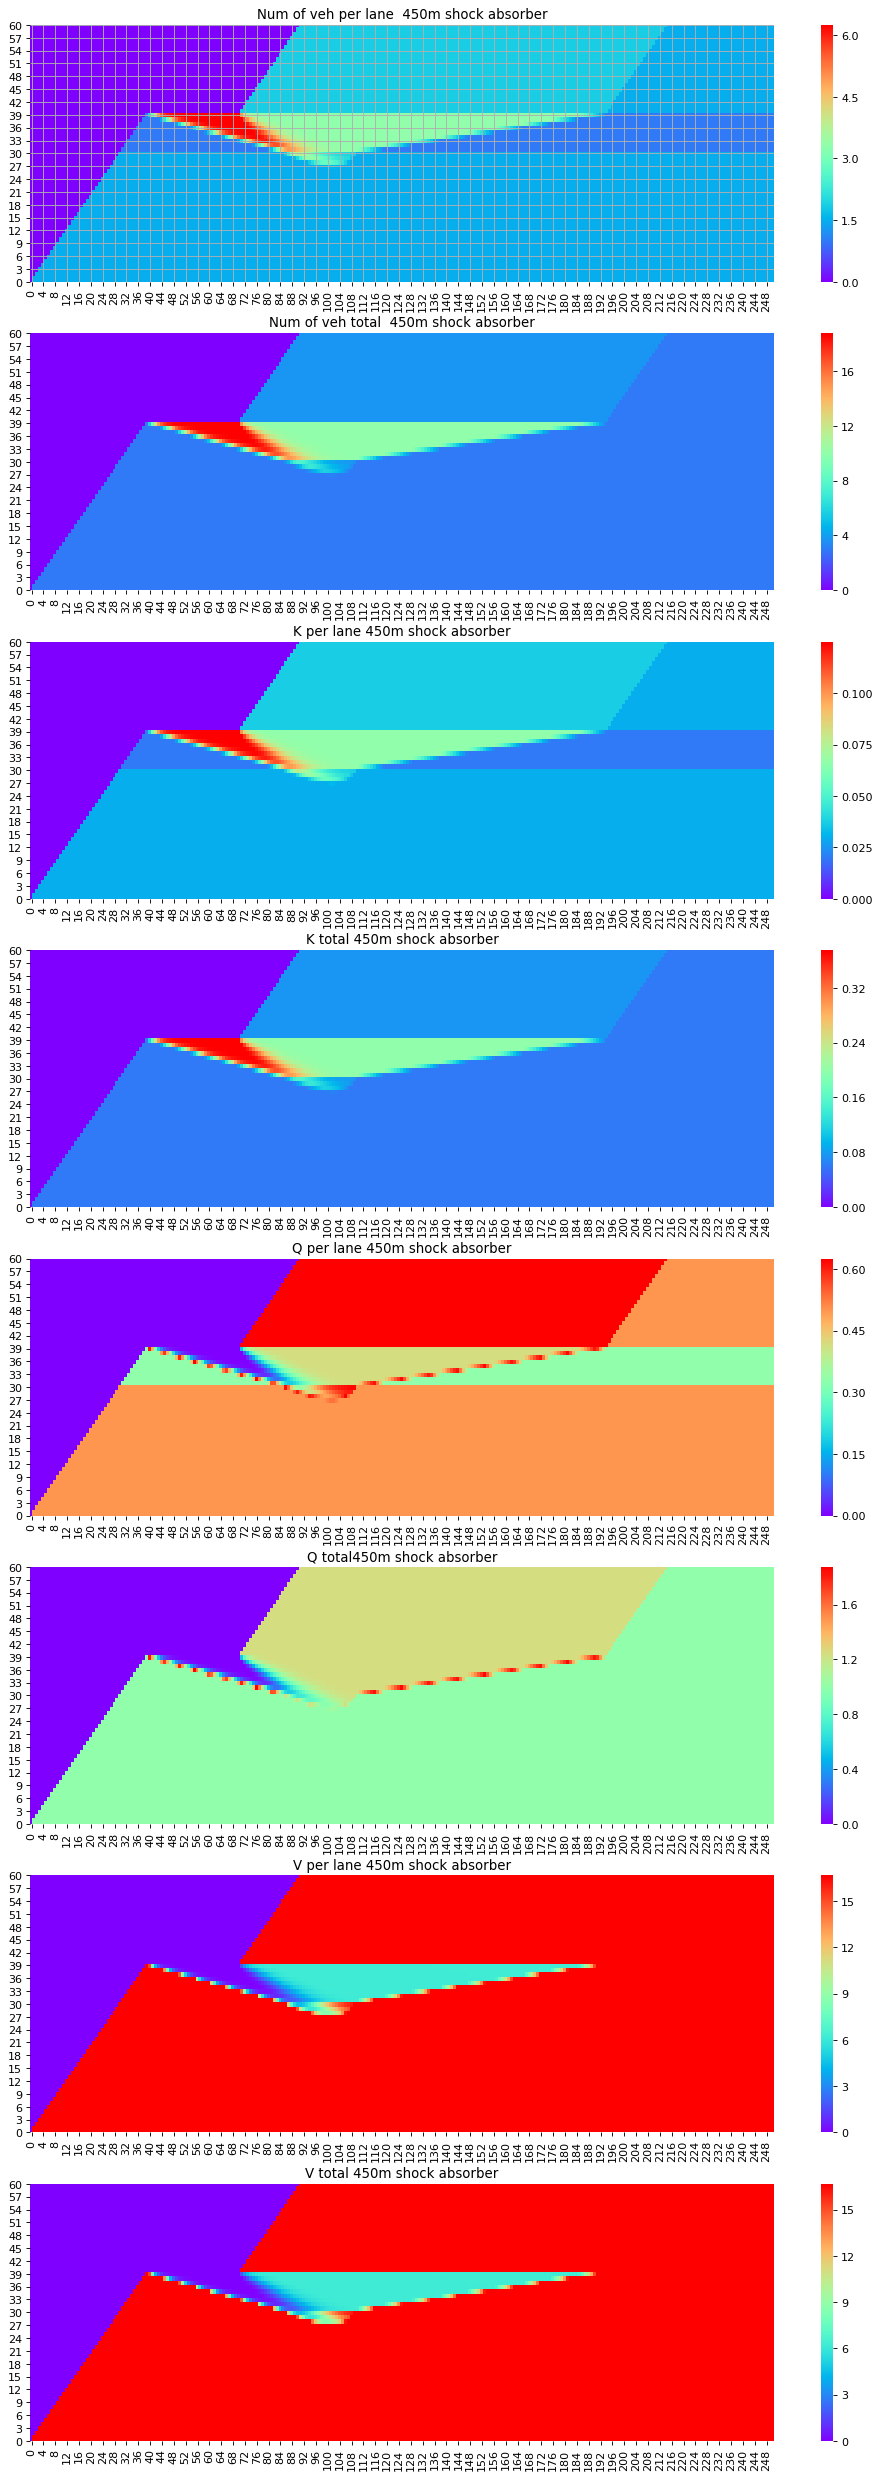

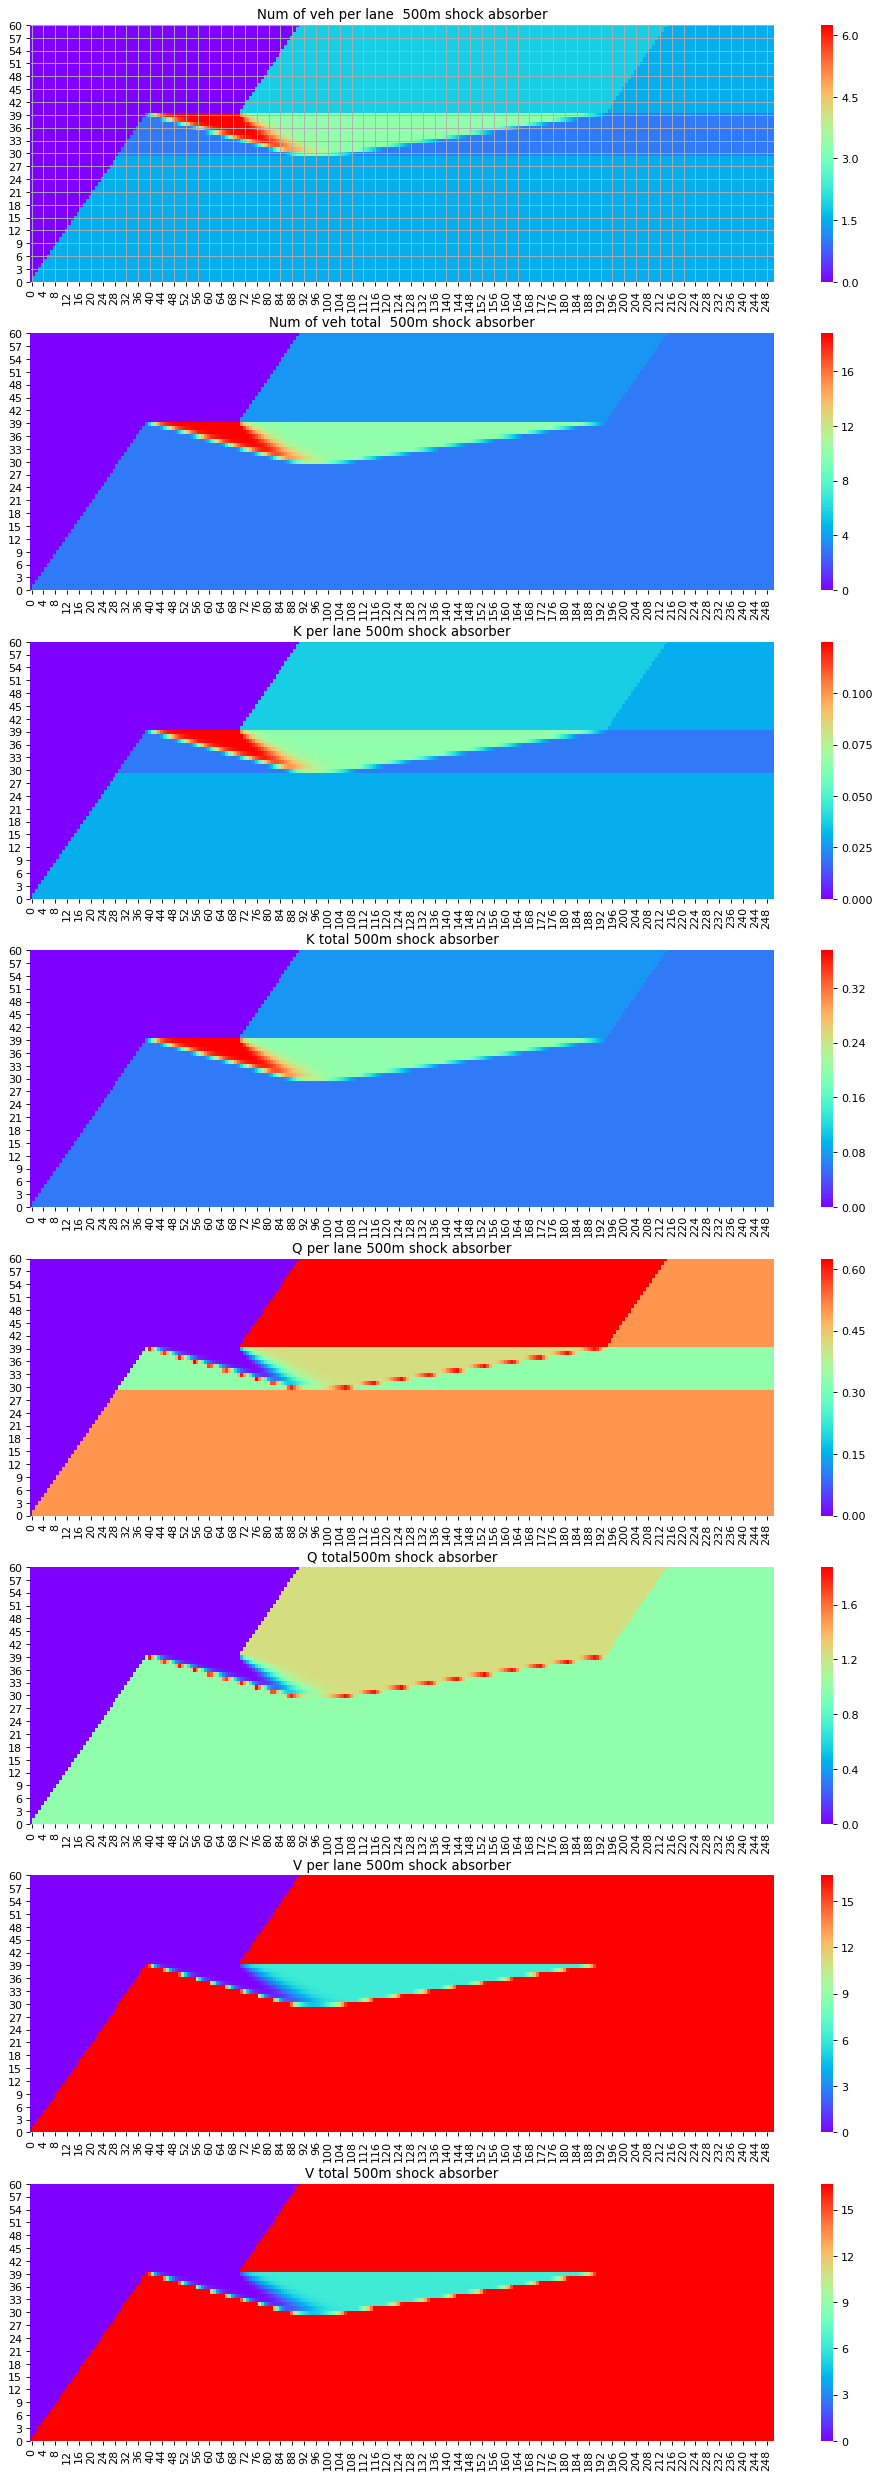

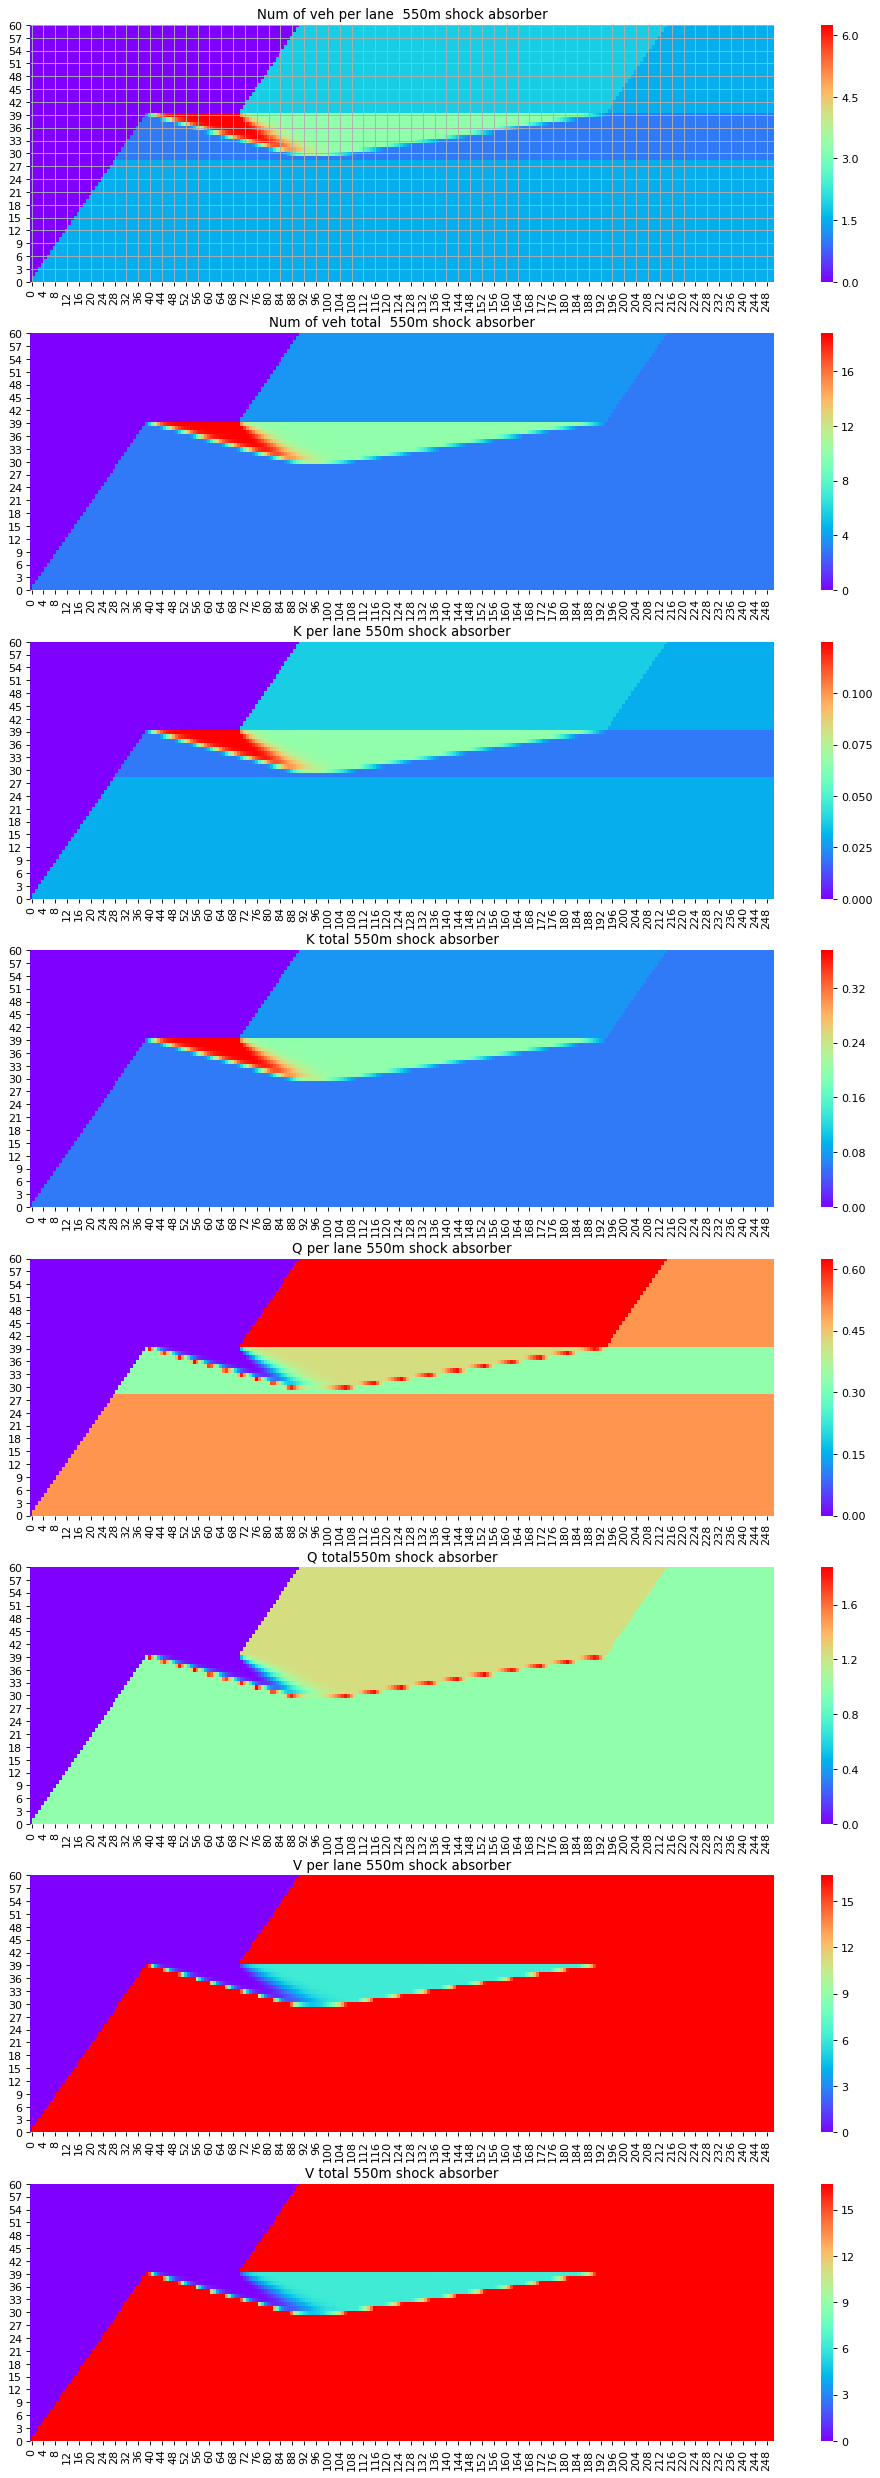

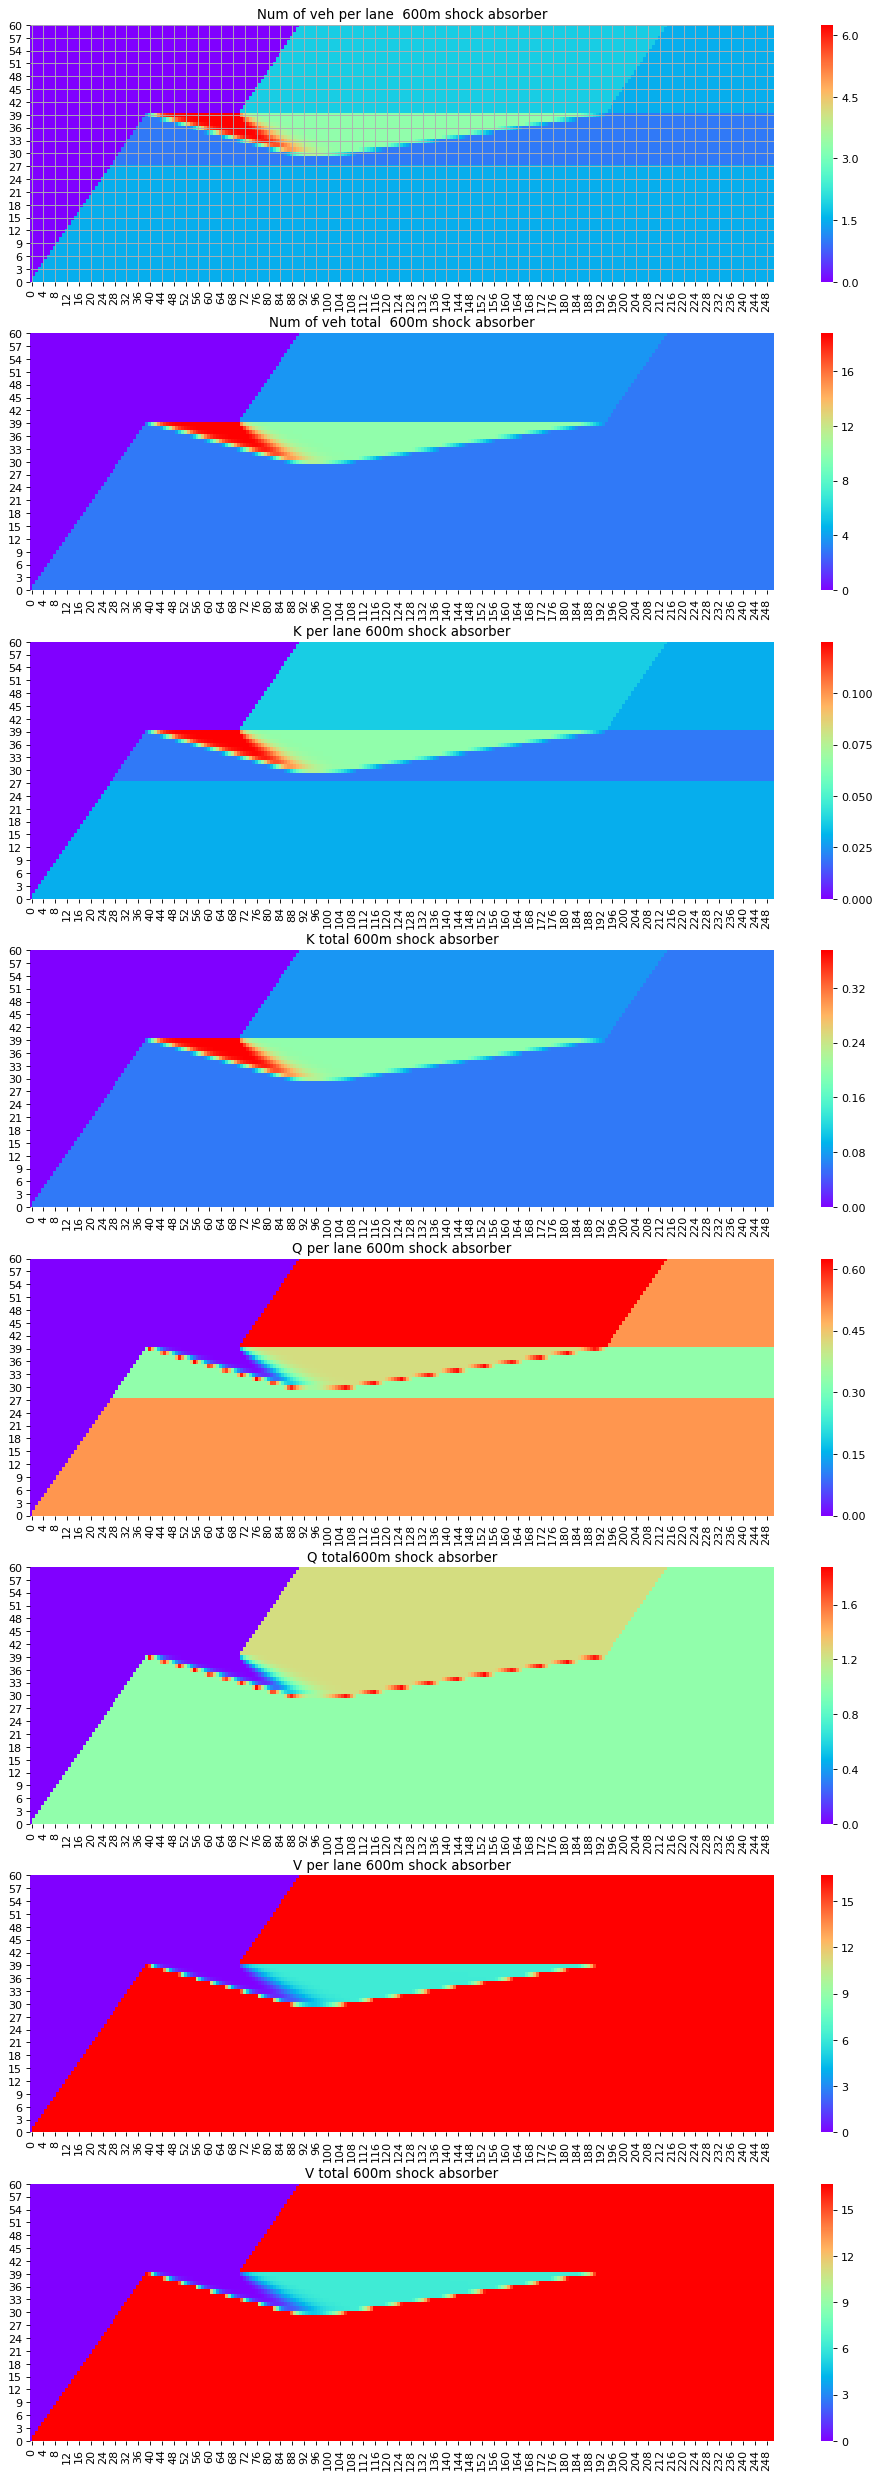

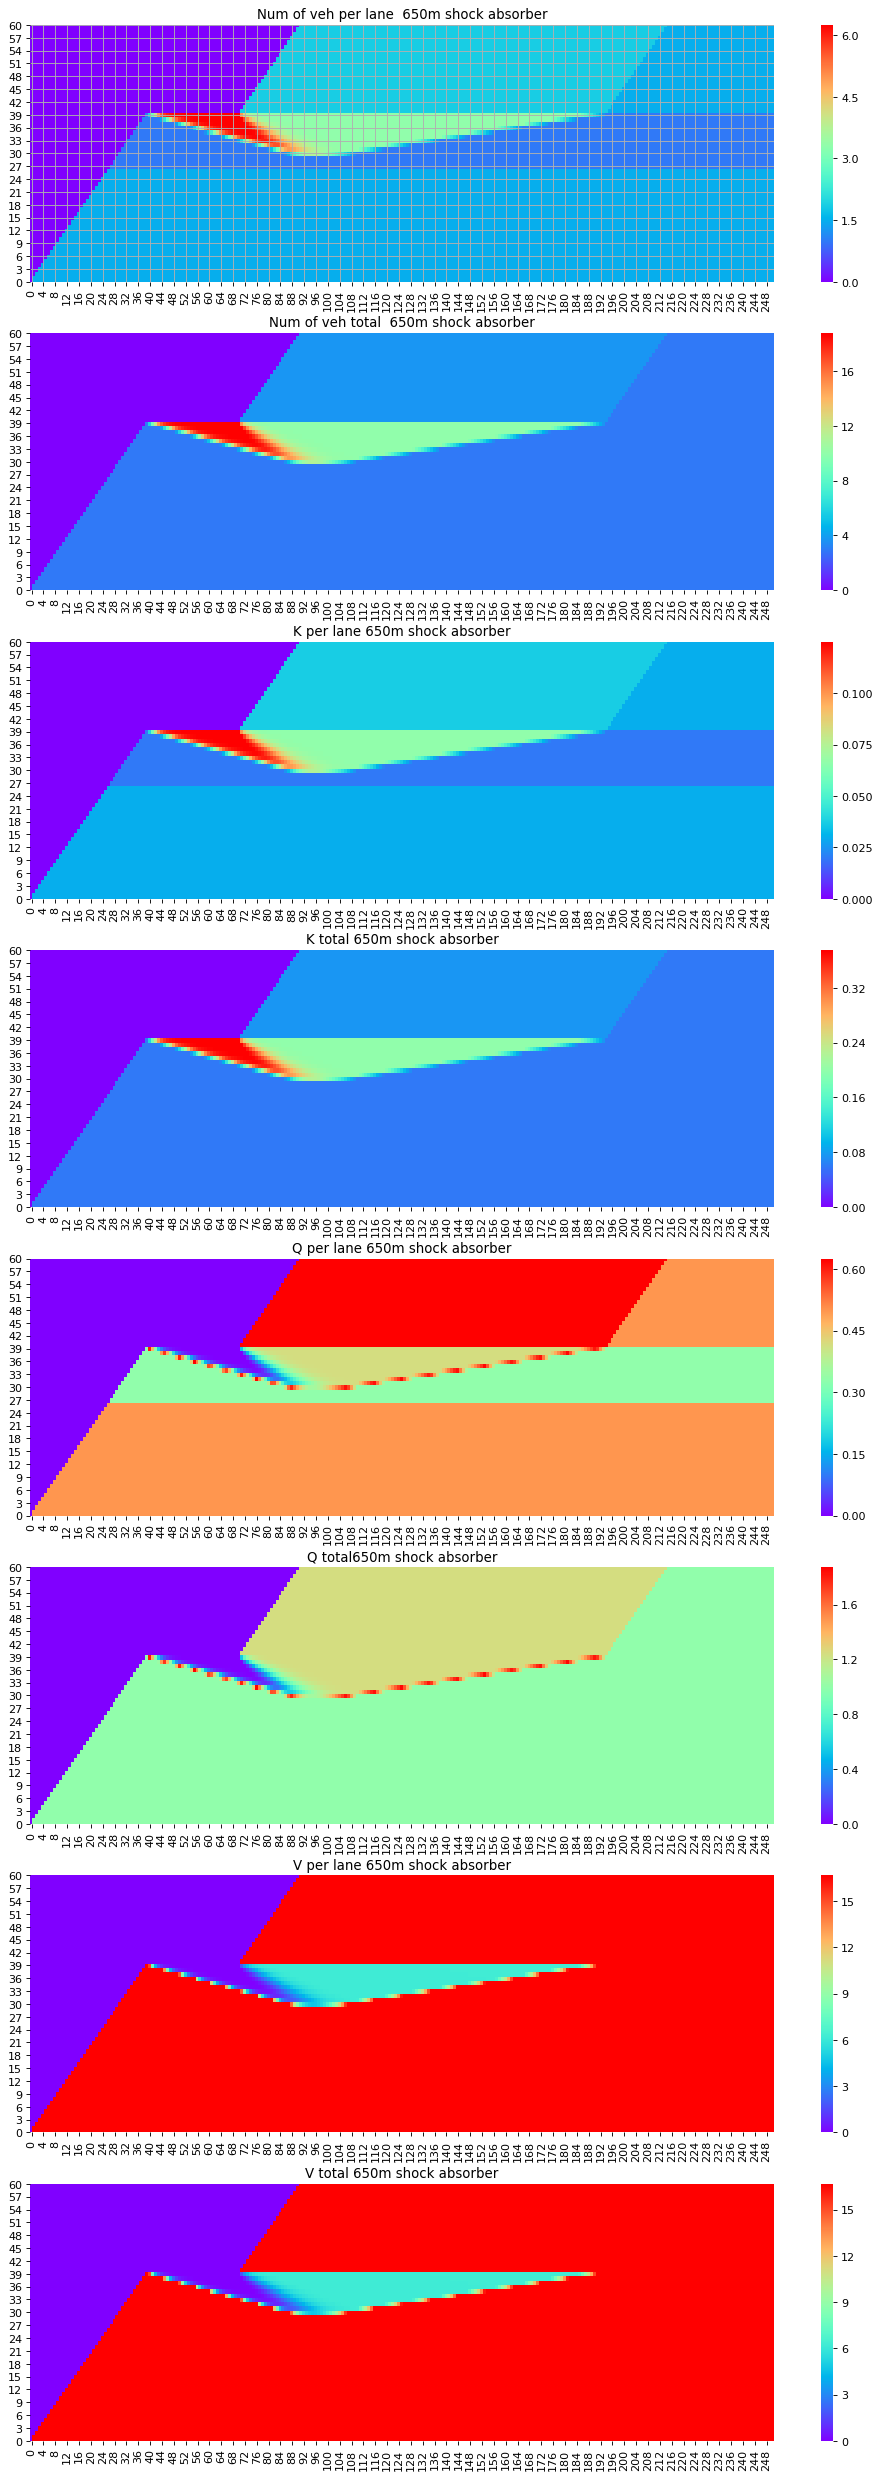

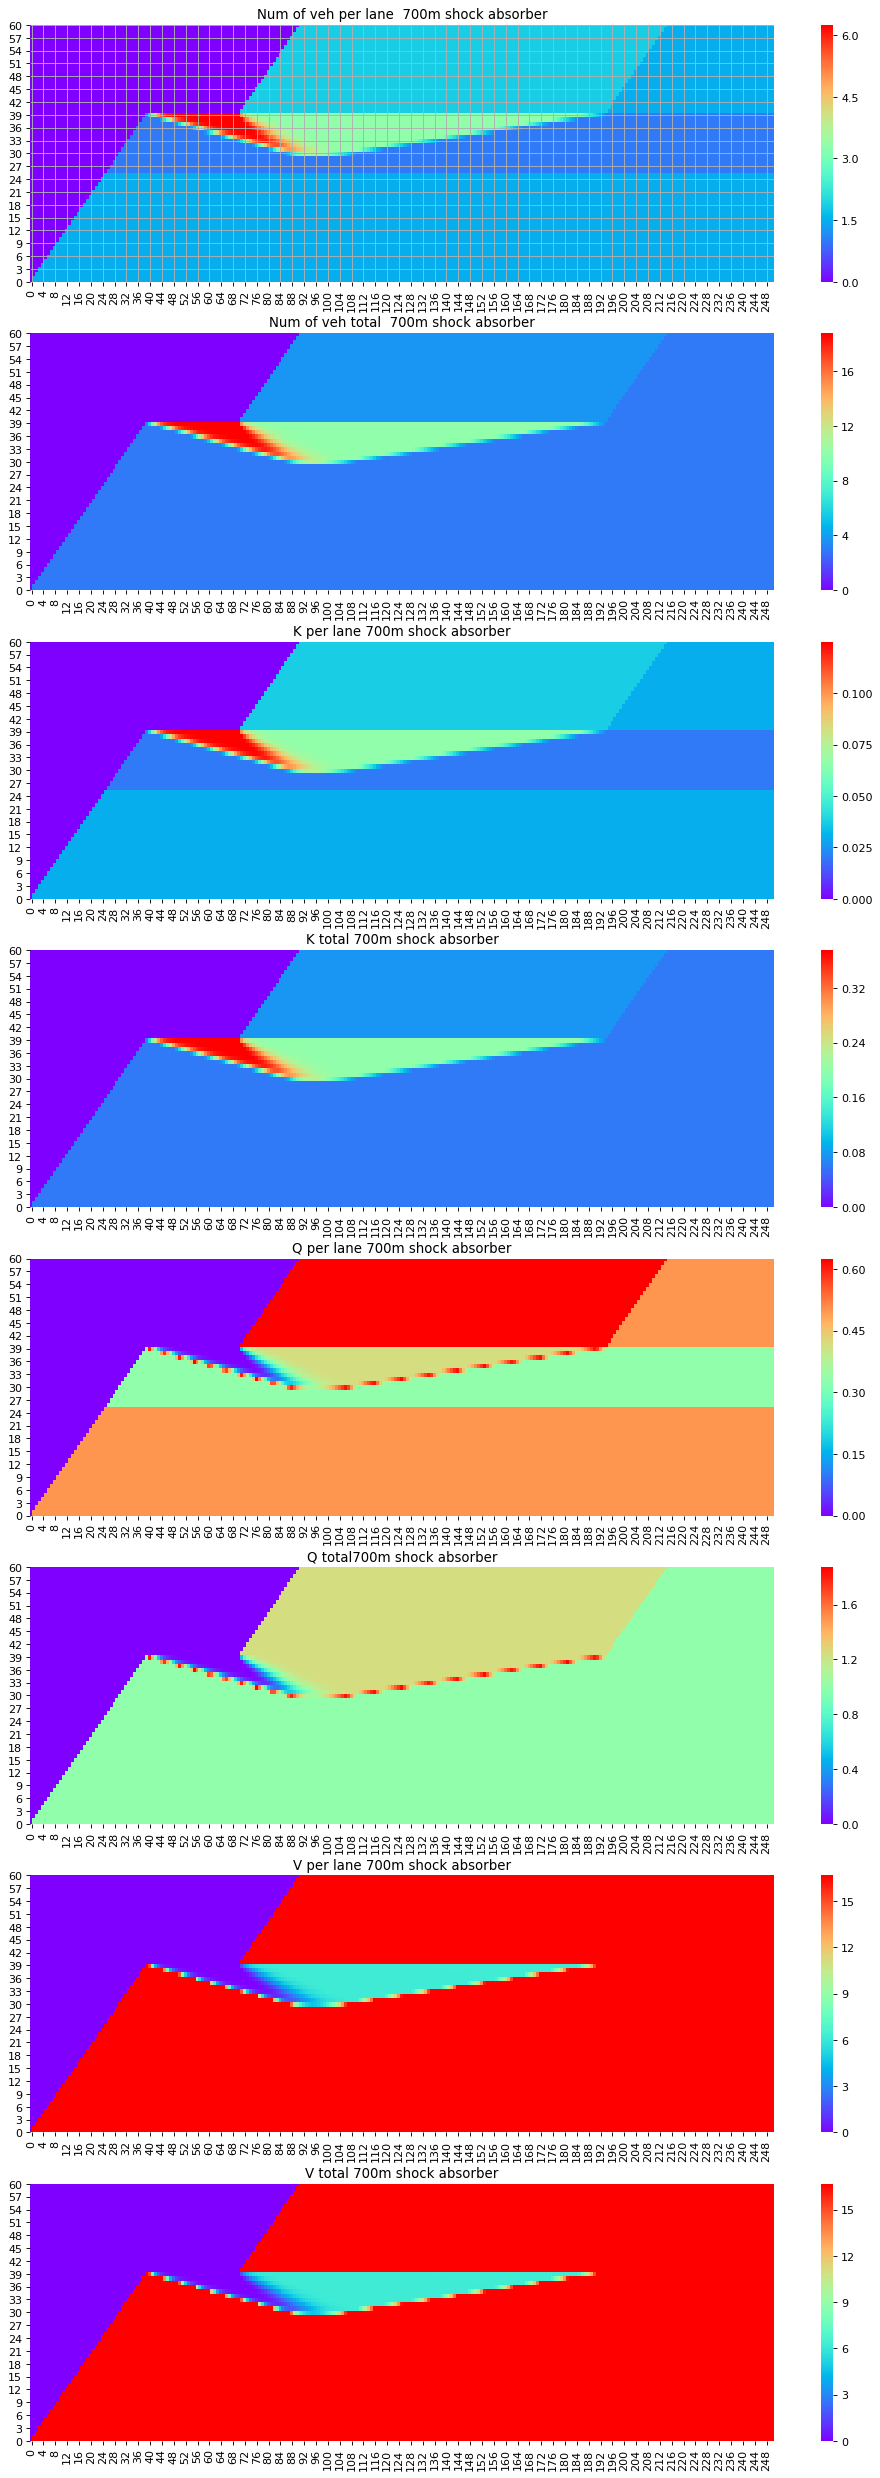

In [5]:
end  = 40
for i in range(0,15):
    start = end-i
    result = pic(start,end)
    
    fig = plt.figure(num=1, figsize=(15, 40),dpi=80)
    ax1 = fig.add_subplot(8,1,1)
    ax2 = fig.add_subplot(8,1,2)
    ax3 = fig.add_subplot(8,1,3)
    ax4 = fig.add_subplot(8,1,4)
    ax5 = fig.add_subplot(8,1,5)
    ax6 = fig.add_subplot(8,1,6)
    ax7 = fig.add_subplot(8,1,7)
    ax8 = fig.add_subplot(8,1,8)

    ax1.set_title('Num of veh per lane  '+str(i*50)+'m '+'shock absorber') 
    ax2.set_title('Num of veh total  '+str(i*50)+'m '+'shock absorber')
    ax3.set_title('K per lane '+str(i*50)+'m '+'shock absorber')
    ax4.set_title('K total '+str(i*50)+'m '+'shock absorber')
    ax5.set_title('Q per lane '+str(i*50)+'m '+'shock absorber')
    ax6.set_title('Q total'+str(i*50)+'m '+'shock absorber')
    ax7.set_title('V per lane '+str(i*50)+'m '+'shock absorber')
    ax8.set_title('V total '+str(i*50)+'m '+'shock absorber')

    sns.heatmap(data=np.rot90(result[0][::-1], -1), vmin = 0,ax = ax1, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[1][::-1], -1), vmin = 0,ax = ax2, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[2][::-1], -1), vmin = 0,ax = ax3, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[3][::-1], -1), vmin = 0,ax = ax4, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[4][::-1], -1), vmin = 0,ax = ax5, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[5][::-1], -1), vmin = 0,ax = ax6, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[6][::-1], -1), vmin = 0,ax = ax7, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[7][::-1], -1), vmin = 0,ax = ax8, cmap='rainbow') 
    
    ax1.xaxis.grid(True, which='major')      
    ax1.yaxis.grid(True, which='major')      
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    ax4.invert_yaxis()
    ax5.invert_yaxis()
    ax6.invert_yaxis()
    ax7.invert_yaxis()
    ax8.invert_yaxis()

    plt.savefig(str(i*50)+'m2 '+'.jpg',dpi=400,bbox_inches='tight')   
    plt.show()    

各种交通流信息显而易见